In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from typing import Optional
from numpy import ndarray
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import pywt
#from scipy import signal
from scipy.optimize import curve_fit

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import scipy
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']


def euler_from_quaternion(df):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        quaternion_cols = ['Rotation X', 'Rotation Y', 'Rotation Z', 'Rotation W']
        Euler_dic = {'Roll_X': [], 'Pitch_Y': [], 'Yaw_Z': []}
        for i in range(len(df)):
          x,y,z,w = df[quaternion_cols].iloc[i,:]
          t0 = +2.0 * (w * x + y * z)
          t1 = +1.0 - 2.0 * (x * x + y * y)
          roll_x = math.atan2(t0, t1)

          t2 = +2.0 * (w * y - z * x)
          t2 = +1.0 if t2 > +1.0 else t2
          t2 = -1.0 if t2 < -1.0 else t2
          pitch_y = math.asin(t2)

          t3 = +2.0 * (w * z + x * y)
          t4 = +1.0 - 2.0 * (y * y + z * z)
          yaw_z = math.atan2(t3, t4)
          Euler_dic['Roll_X'].append(roll_x)
          Euler_dic['Pitch_Y'].append(pitch_y)
          Euler_dic['Yaw_Z'].append(yaw_z)
        Euler_df = pd.DataFrame.from_dict(Euler_dic)

        return Euler_df

def get_cartesian_velocities(mocap_df):
  t = len(mocap_df)
  mocap_vel_df = pd.DataFrame(columns = ['Vel_X', 'Vel_Y', 'Vel_Z'])
  time = np.linspace(0, t, len(mocap_df))
  x_positions = mocap_df['Position X'].values
  y_positions = mocap_df['Position Y'].values
  z_positions = mocap_df['Position Z'].values
  # Calculate velocities using differences in positions and time
  # Velocity = change in position / change in time (v = Δx / Δt)
  delta_x = np.diff(x_positions)
  delta_y = np.diff(y_positions)
  delta_z = np.diff(z_positions)
  delta_t = np.diff(time)
  print(f"len delta_x = {len(delta_x)} \t len delta_t = {len(delta_t)}")
  # Calculate velocities in each dimension (x, y, z)

  mocap_vel_df['Vel_X'] = np.gradient(x_positions, time[1])
  mocap_vel_df['Vel_Y'] = np.gradient(y_positions, time[1]) #delta_y / delta_t
  mocap_vel_df['Vel_Z'] = np.gradient(z_positions, time[1]) #delta_z / delta_t
  mocap_vel_df.loc[len(mocap_df)-1] = [0,0,0]
  return mocap_vel_df




# Data reading and imputation

## FT data Reading, preprocessing and denoising

In [3]:
# FT data reading and preprocessing
import pandas as pd
ft_df = pd.read_csv('Mocap FT data/FT sensor records/csv/mat2_ex1_trial10.csv')
ft_df_test = pd.read_csv('Mocap FT data/FT sensor records/csv/mat2_ex1_trial9.csv')

# remove unwanted col from the df_ft
ft_df = ft_df.drop('Unnamed: 0', axis=1)
ft_df_test = ft_df_test.drop('Unnamed: 0', axis=1)
# verify missing data
ft_df.isnull().sum()
ft_df_test.isnull().sum()

 Fx    0
 Fy    0
 Fz    0
 Tx    0
 Ty    0
 Tz    0
dtype: int64

## Mocap Data Reading and preprocessing

In [4]:
# 1. MoCap DATA READING
raw_mocap_df = pd.read_csv("csv/scalp_trajectories/mat2_Ex1_trial_010.csv")
raw_mocap_df_test = pd.read_csv("csv/scalp_trajectories/mat2_Ex1_trial_009.csv")
cols_to_keep = ['Rotation X',  'Rotation Y',  'Rotation Z', 'Rotation W','Position X',  'Position Y',  'Position Z']
df = raw_mocap_df[cols_to_keep]
df_9 = raw_mocap_df_test[cols_to_keep]
# 2- DATA PREPROCESSING

# 2.1-  Count NaN values in each column
nan_count = df.isnull().sum()

# 2.2- Calculate NaN percentage for each column
nan_percentage = (nan_count / len(df)) * 100

# 2.3- Drop columns with NaN percentage above 40%
  # It is necessary to excclude the features that have high missing data ratio
  # As it affect the model training process and lead to bad perdiction
threshold = 40
columns_to_drop = nan_percentage[nan_percentage > threshold].index
df_dropped = df.drop(columns=columns_to_drop)

print("Original DataFrame:")
print(df)
print("\nDataFrame after dropping columns with NaN percentage above", threshold, "percent:")
print(df_dropped)


#2.5- Estimating missing values using linear interpolation
data_imputed =df_dropped.interpolate(method='linear', axis=0)
data_imputed_9 =df_9.interpolate(method='linear', axis=0)

print("\nImputed dataset:")
print(data_imputed)

# Create a new DataFrame with normailized imputed values
mocap_df = data_imputed.copy()
mocap_df_9 = data_imputed_9.copy()
columns_names = list(mocap_df.columns)
# Check if any missing data exists after the preprocessing and imputattion
mocap_df.isnull().sum()
mocap_df_9.isnull().sum()

Original DataFrame:
      Rotation X  Rotation Y  Rotation Z  Rotation W  Position X  Position Y  \
0       0.708305    0.280167   -0.575357   -0.297951    0.921725    1.712022   
1       0.649235    0.166014   -0.616799   -0.412906    0.911333    1.719669   
2       0.707399    0.278253   -0.576568   -0.299551    0.921857    1.712050   
3       0.649357    0.165939   -0.616854   -0.412663    0.911493    1.719591   
4       0.707939    0.279082   -0.576092   -0.298419    0.922027    1.711914   
...          ...         ...         ...         ...         ...         ...   
3158    0.387690   -0.338485   -0.662940   -0.543723    0.838153    1.702327   
3159    0.387656   -0.338421   -0.662977   -0.543742    0.838161    1.702332   
3160    0.387652   -0.338401   -0.662995   -0.543736    0.838145    1.702307   
3161    0.387825   -0.338320   -0.662980   -0.543681    0.838154    1.702298   
3162    0.387806   -0.338211   -0.663092   -0.543626    0.838147    1.702315   

      Position Z  


Rotation X    0
Rotation Y    0
Rotation Z    0
Rotation W    0
Position X    0
Position Y    0
Position Z    0
dtype: int64

### Get Euler from quaternions

   Position X  Position Y  Position Z    Roll_X   Pitch_Y     Yaw_Z
0    0.921725    1.712022   -0.378666 -1.782980  0.705093  1.330906
1    0.911333    1.719669   -0.376053 -1.434170  0.725886  1.322230
2    0.921857    1.712050   -0.378515 -1.776883  0.706303  1.331536
3    0.911493    1.719591   -0.375983 -1.434471  0.726374  1.322239
4    0.922027    1.711914   -0.378470 -1.780197  0.706413  1.331279


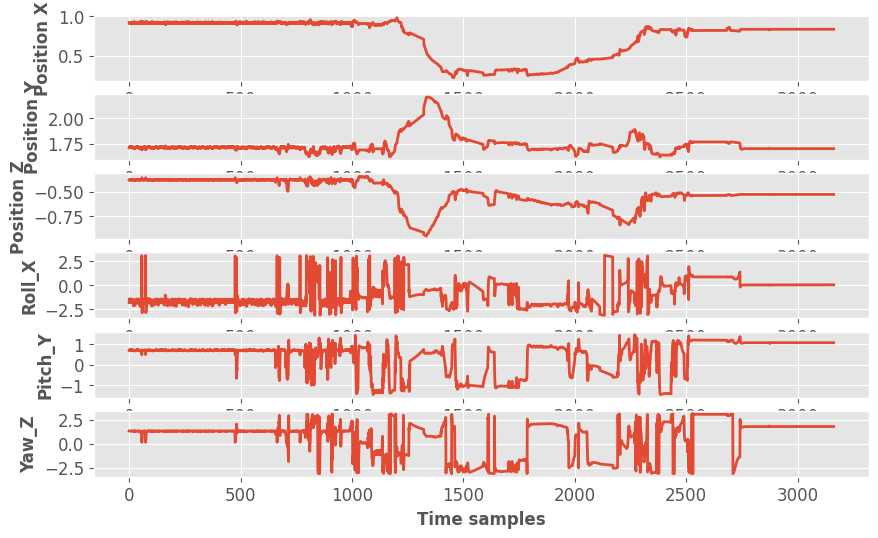

In [6]:
mocap_df_q = mocap_df.copy()
cols_to_remove = ['Rotation X','Rotation Y', 'Rotation Z', 'Rotation W']
Euler_df = euler_from_quaternion(mocap_df_q)
mocap_df[Euler_df.columns] = Euler_df
mocap_df_q = mocap_df_q.drop(cols_to_remove, axis=1)
print(mocap_df_q.head())
plt.figure(figsize=(10,6))
for i, c in enumerate(mocap_df_q.columns):
  plt.subplot(6,1,i+1)
  plt.plot(mocap_df_q[c], label=f'{c}')
  plt.xlabel('Time samples')
  plt.ylabel(f'{c}')


   Position X  Position Y  Position Z    Roll_X   Pitch_Y     Yaw_Z
0    0.912554    1.652089   -0.371950 -0.704501  1.270856 -2.817486
1    0.912573    1.652097   -0.371931 -0.705200  1.270319 -2.817789
2    0.912578    1.652103   -0.371942 -0.705329  1.270038 -2.817877
3    0.912576    1.652080   -0.371931 -0.706356  1.269755 -2.818544
4    0.912577    1.652091   -0.371923 -0.706567  1.269629 -2.818807


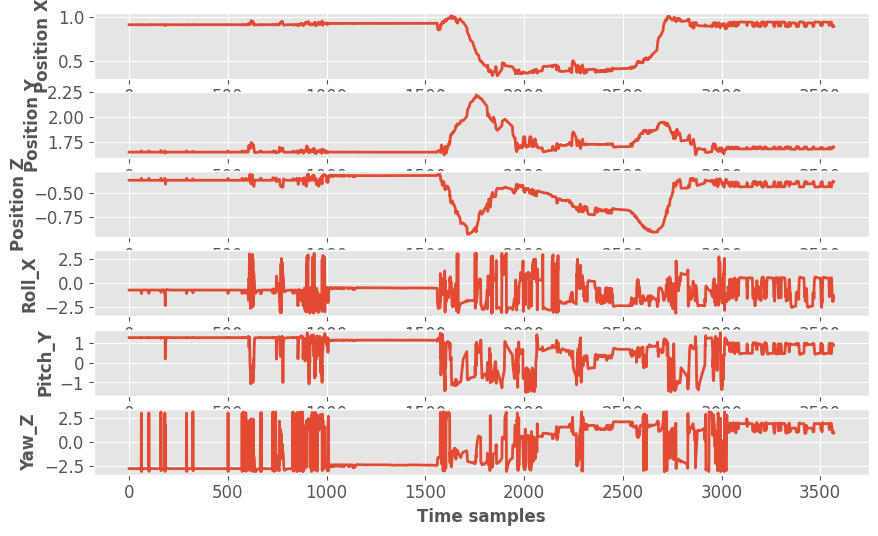

In [8]:
### FOR TEST DATA
mocap_df_q_9 = mocap_df_9.copy()
cols_to_remove = ['Rotation X','Rotation Y', 'Rotation Z', 'Rotation W']
Euler_df = euler_from_quaternion(mocap_df_q_9)
mocap_df_9[Euler_df.columns] = Euler_df
mocap_df_q_9 = mocap_df_q_9.drop(cols_to_remove, axis=1)
print(mocap_df_q_9.head())
plt.figure(figsize=(10,6))
for i, c in enumerate(mocap_df_q_9.columns):
  plt.subplot(6,1,i+1)
  plt.plot(mocap_df_q_9[c], label=f'{c}')
  plt.xlabel('Time samples')
  plt.ylabel(f'{c}')

### Calculate Cartesian Velocities (TODO: Calc them in final step after synchronisation and filtering)

In [6]:
mocap_df_vel = get_cartesian_velocities(mocap_df_q)
mocap_df_vel

len delta_x = 3162 	 len delta_t = 3162


,Vel_X,Vel_Y,Vel_Z
0,-1.038871e-02,0.007645,0.002612
1,6.597913e-05,0.000014,0.000075
2,7.997471e-05,-0.000039,0.000035
3,8.497313e-05,-0.000068,0.000022
4,7.347676e-05,-0.000075,-0.000003
...,...,...,...
3158,1.499526e-06,-0.000002,0.000000
3159,-3.998735e-06,-0.000010,-0.000001
3160,-3.498893e-06,-0.000017,-0.000004
3161,9.996838e-07,0.000004,0.000011


In [7]:
print(mocap_df_vel.max())
print(mocap_df_vel.min())

Vel_X    0.029820
Vel_Y    0.042529
Vel_Z    0.048524
dtype: float64
Vel_X   -0.036948
Vel_Y   -0.049137
Vel_Z   -0.038033
dtype: float64


C:\Users\wadda\AppData\Local\Temp\ipykernel_21736\2156054243.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)


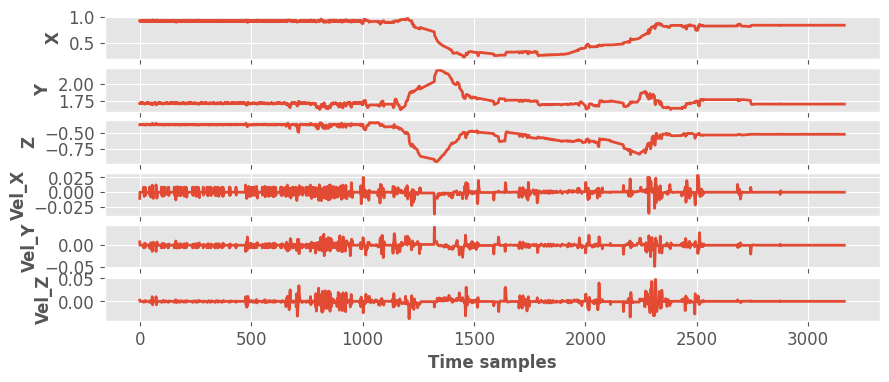

In [8]:
mocap_df_q[mocap_df_vel.columns] = mocap_df_vel
mocap_df_q
cols_to_vis = ['Position X', 'Position Y', 'Position Z', 'Vel_X','Vel_Y', 'Vel_Z']
plt.figure(figsize=(10,6))
for i,c in enumerate(mocap_df_q[cols_to_vis]):
  plt.subplot(9,1,i+1)
  plt.plot(mocap_df_q[c])
  plt.ylabel(c.split(" ")[-1])
plt.xlabel('Time samples')
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

### Data Synchronization

In [9]:
# Set the index of MoCap data to DatetimeIndex (assuming it's sequential)
# Calculate the time sampling value in ms for upsampling mocap_df (freq=100Hz) to match the frequency og ft_df(7000Hz)

ft_freq = 7000  # FT data frequency (7000Hz)
upsample_ratio = np.round(1000 / ft_freq, 5)  # Calculate the ratio (1sec = 1000 ms)
mocap_data = mocap_df_q.copy()
mocap_data.set_index(pd.date_range(start='2023-01-01', periods=len(mocap_data), freq='10ms'), inplace=True)
# Here, '10ms' represents the 100Hz sampling rate (adjust if needed)


print(f"Mocap length before resampling: {len(mocap_data)}")
mocap_data.head()
# Resample the MoCap data to match the FT data's frequency (7000Hz)
resampled_mocap_data = mocap_data.resample(f'{upsample_ratio}ms').fillna(method='ffill')

# Resample the MoCap data to match the FT data's frequency
print(f"Mocap length after upsampling: {len(resampled_mocap_data)}")

ft_data = ft_df.copy()
ft_data.set_index(pd.date_range(start='2023-01-01', periods=len(ft_data), freq=f'{upsample_ratio}ms'), inplace=True)
ft_data = ft_data[ft_data.columns][:len(resampled_mocap_data)]
print(f"ft length: {len(ft_data)}")


synchronized_data = pd.concat([resampled_mocap_data, ft_data], axis=1)

# synchronized_data.to_csv('/content/res.csv')

Mocap length before resampling: 3163
Mocap length after upsampling: 221336
ft length: 221336


C:\Users\wadda\AppData\Local\Temp\ipykernel_15588\3497364349.py:14: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  resampled_mocap_data = mocap_data.resample(f'{upsample_ratio}ms').fillna(method='ffill')


In [10]:
#### For TEST DATA
# Set the index of MoCap data to DatetimeIndex (assuming it's sequential)
# Calculate the time sampling value in ms for upsampling mocap_df (freq=100Hz) to match the frequency og ft_df(7000Hz)

ft_freq = 7000  # FT data frequency (7000Hz)
upsample_ratio = np.round(1000 / ft_freq, 5)  # Calculate the ratio (1sec = 1000 ms)
mocap_data_9 = mocap_df_q_9.copy()
mocap_data_9.set_index(pd.date_range(start='2023-01-01', periods=len(mocap_data_9), freq='10ms'), inplace=True)
# Here, '10ms' represents the 100Hz sampling rate (adjust if needed)


print(f"Mocap length before resampling: {len(mocap_data_9)}")
mocap_data_9.head()
# Resample the MoCap data to match the FT data's frequency (7000Hz)
resampled_mocap_data_9 = mocap_data_9.resample(f'{upsample_ratio}ms').fillna(method='ffill')

# Resample the MoCap data to match the FT data's frequency
print(f"Mocap length after upsampling: {len(resampled_mocap_data_9)}")

ft_data_test = ft_df_test.copy()
ft_data_test.set_index(pd.date_range(start='2023-01-01', periods=len(ft_data_test), freq=f'{upsample_ratio}ms'), inplace=True)
ft_data_test = ft_data_test[ft_data_test.columns][:len(resampled_mocap_data_9)]
print(f"ft length: {len(ft_data_test)}")


synchronized_data_9 = pd.concat([resampled_mocap_data_9, ft_data_test], axis=1)

Mocap length before resampling: 3569
Mocap length after upsampling: 249756
ft length: 249756


C:\Users\wadda\AppData\Local\Temp\ipykernel_15588\1889676367.py:15: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  resampled_mocap_data_9 = mocap_data_9.resample(f'{upsample_ratio}ms').fillna(method='ffill')


In [81]:
synchronized_data_9

,Position X,Position Y,Position Z,Roll_X,Pitch_Y,Yaw_Z,Fx,Fy,Fz,Tx,Ty,Tz
2023-01-01 00:00:00.000000000,0.912554,1.652089,-0.371950,-0.704501,1.270856,-2.817486,52.0,54.0,35.0,80.0,17.0,9.0
2023-01-01 00:00:00.000142860,0.912554,1.652089,-0.371950,-0.704501,1.270856,-2.817486,59.0,56.0,34.0,81.0,18.0,11.0
2023-01-01 00:00:00.000285720,0.912554,1.652089,-0.371950,-0.704501,1.270856,-2.817486,54.0,55.0,31.0,81.0,19.0,12.0
2023-01-01 00:00:00.000428580,0.912554,1.652089,-0.371950,-0.704501,1.270856,-2.817486,55.0,56.0,36.0,82.0,18.0,10.0
2023-01-01 00:00:00.000571440,0.912554,1.652089,-0.371950,-0.704501,1.270856,-2.817486,59.0,56.0,35.0,79.0,16.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01 00:00:35.679427860,0.902562,1.695925,-0.390899,-1.826709,0.890358,1.029838,57.0,58.0,38.0,81.0,20.0,14.0
2023-01-01 00:00:35.679570720,0.902562,1.695925,-0.390899,-1.826709,0.890358,1.029838,55.0,53.0,32.0,80.0,20.0,13.0
2023-01-01 00:00:35.679713580,0.902562,1.695925,-0.390899,-1.826709,0.890358,1.029838,57.0,58.0,31.0,80.0,14.0,8.0
2023-01-01 00:00:35.679856440,0.902562,1.695925,-0.390899,-1.826709,0.890358,1.029838,55.0,56.0,32.0,80.0,20.0,10.0


### Visualize Synchronized data

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


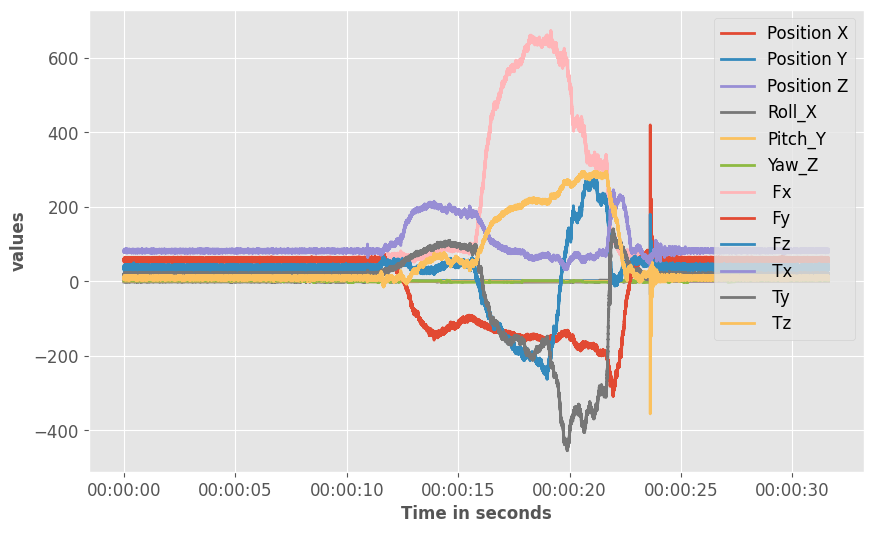

In [8]:
plt.figure(figsize=(10,6))
for c in synchronized_data:
  plt.plot(synchronized_data[c], label=f'{c}')
# for c in ft_data:
#   plt.plot(ft_data[c], label=f'{c}')
plt.xlabel('Time in seconds')
plt.ylabel('values')
plt.legend()

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


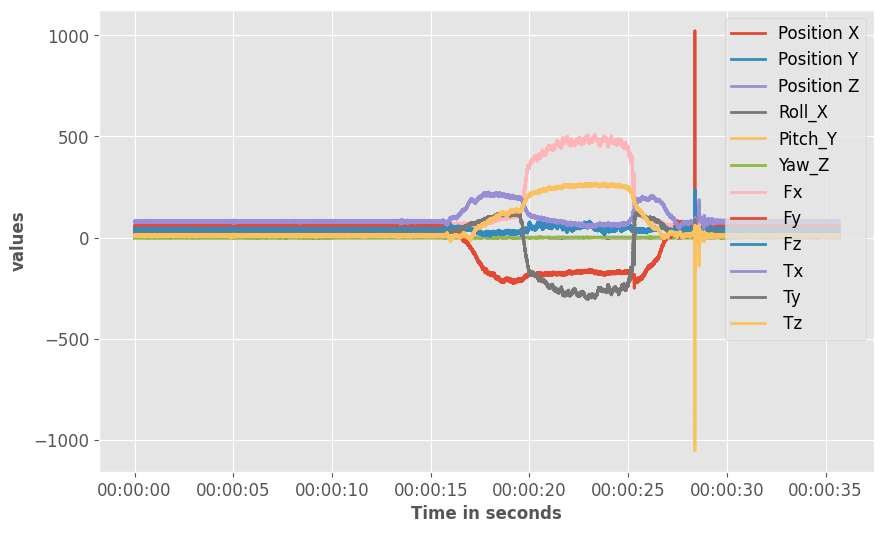

In [59]:
# TEST DATA
plt.figure(figsize=(10,6))
for c in synchronized_data_9.columns:
  plt.plot(synchronized_data_9[c], label=f'{c}')
# for c in ft_data:
#   plt.plot(ft_data[c], label=f'{c}')
plt.xlabel('Time in seconds')
plt.ylabel('values')
plt.legend()

## Denoising FT data (EMA Filter)

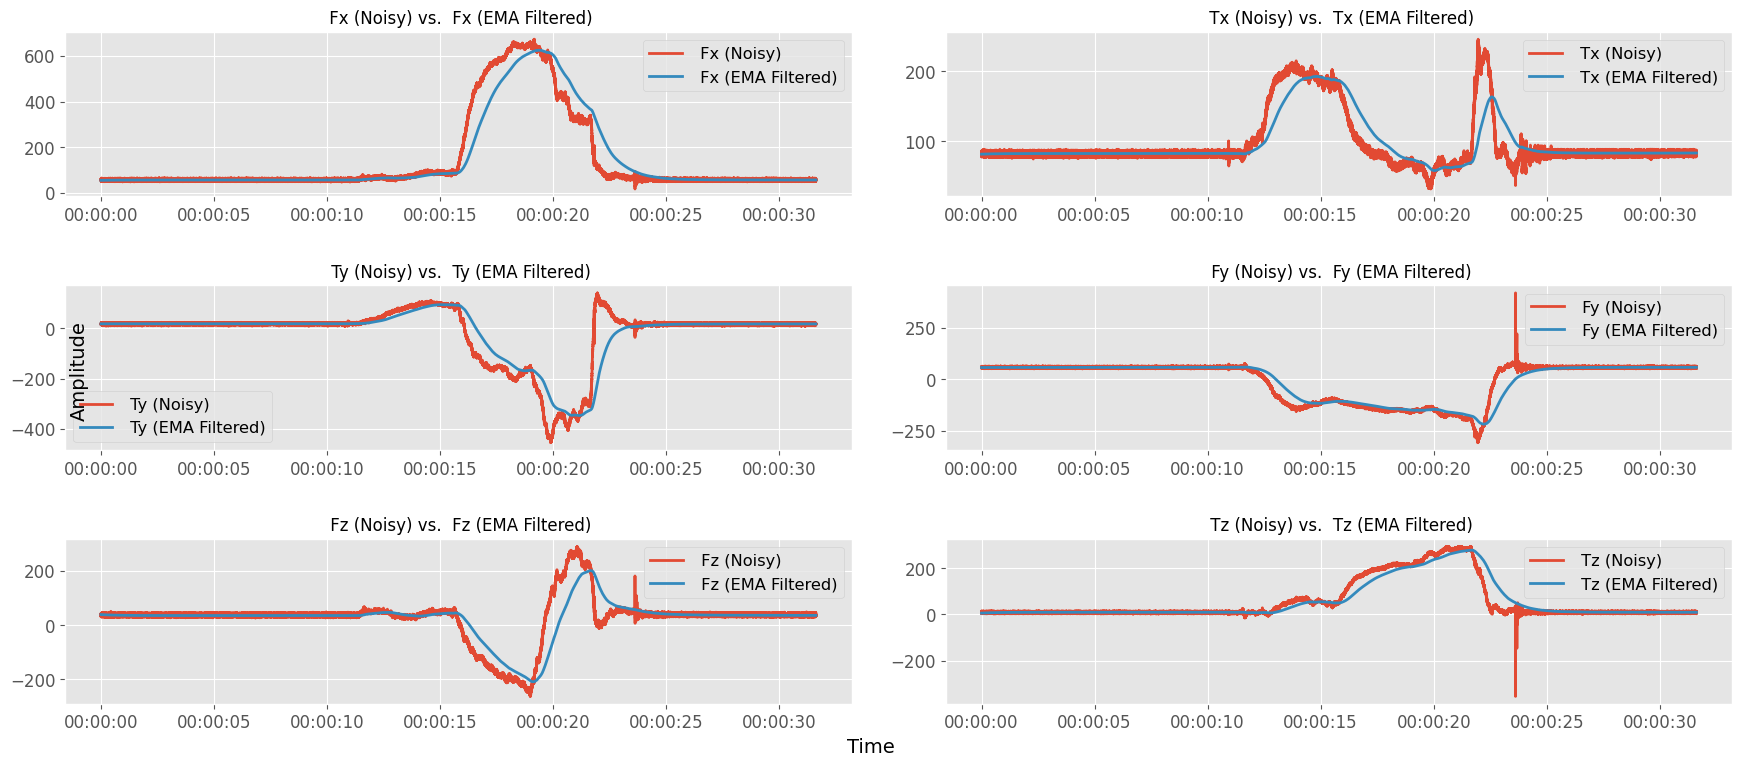

In [11]:
synchronized_data_filtered = synchronized_data.copy()

# Apply Exponential Moving Average (EMA) filter to each column
span = 10000  # Span parameter for EMA (adjust as needed)
ema_filtered = synchronized_data[ft_df.columns].ewm(span=span, adjust=False).mean()

# Adding denoised Ft data to synchronised data
synchronized_data_filtered[ft_df.columns] = ema_filtered
fig, axs = plt.subplots(3, 2, figsize=(18, 8))

for i, col in enumerate(ft_df.columns):

  axs[i%3, i%2].plot(synchronized_data[col], label=f'{col} (Noisy)')
  axs[i%3, i%2].plot(synchronized_data_filtered[col], label=f'{col} (EMA Filtered)')
  axs[i%3, i%2].set_title(f'{col} (Noisy) vs. {col} (EMA Filtered)')
  axs[i%3, i%2].legend(fontsize='small')
# Add labels to the entire figure
fig.text(0.5, 0.03, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
# Adjust layout to prevent overlapping
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

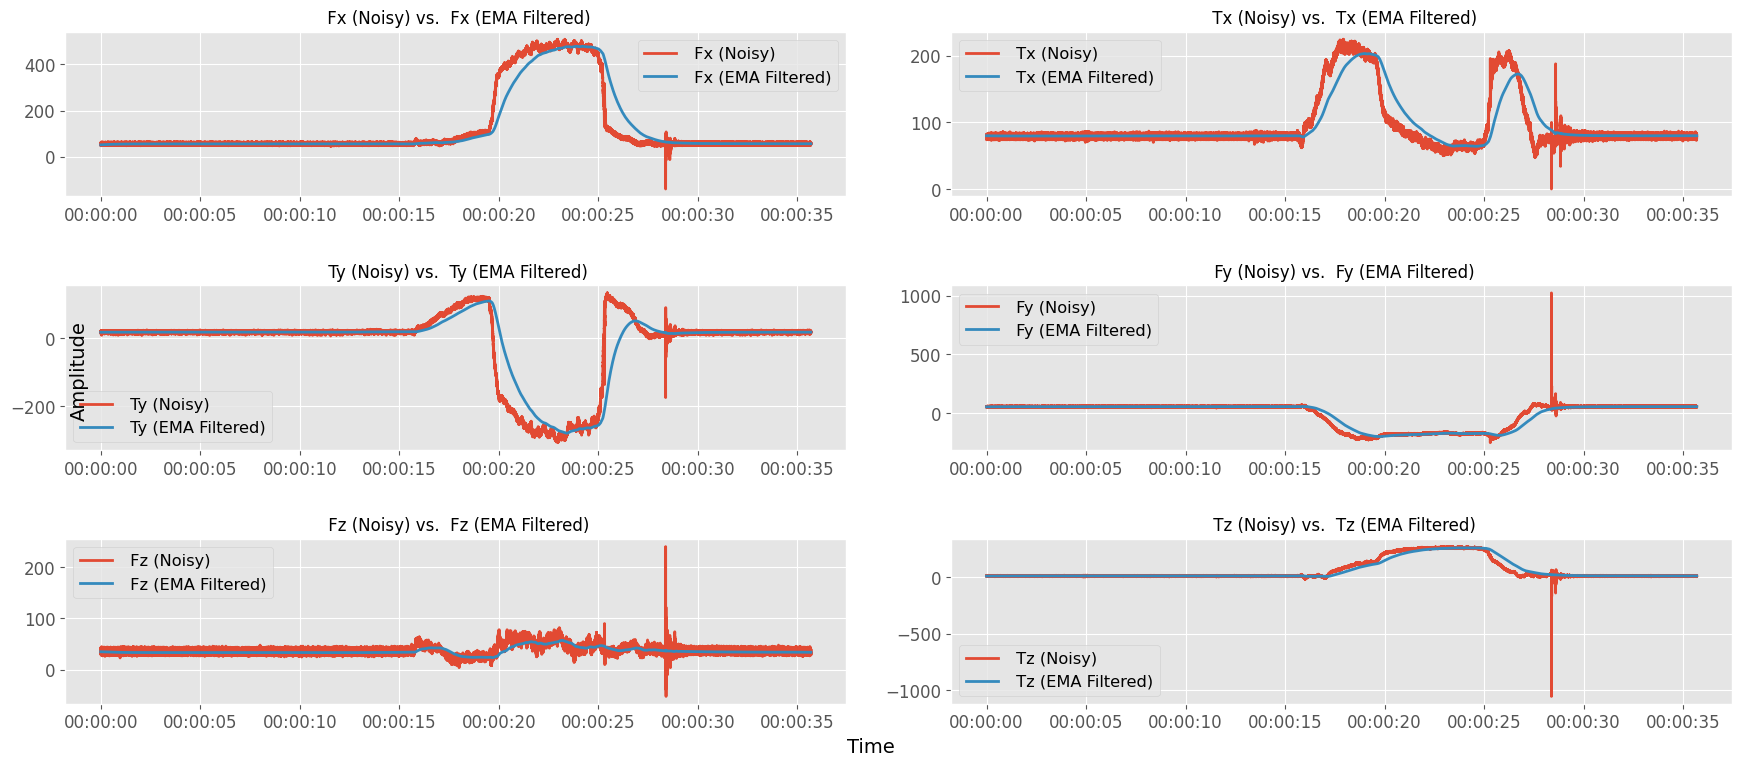

In [12]:
### TEST DATA
synchronized_data_filtered_9 = synchronized_data_9.copy()

# Apply Exponential Moving Average (EMA) filter to each column
span = 10000  # Span parameter for EMA (adjust as needed)
ema_filtered_9 = synchronized_data_9[ft_df.columns].ewm(span=span, adjust=False).mean()

# Adding denoised Ft data to synchronised data
synchronized_data_filtered_9[ft_df_test.columns] = ema_filtered_9
fig, axs = plt.subplots(3, 2, figsize=(18, 8))

for i, col in enumerate(ft_df.columns):

  axs[i%3, i%2].plot(synchronized_data_9[col], label=f'{col} (Noisy)')
  axs[i%3, i%2].plot(synchronized_data_filtered_9[col], label=f'{col} (EMA Filtered)')
  axs[i%3, i%2].set_title(f'{col} (Noisy) vs. {col} (EMA Filtered)')
  axs[i%3, i%2].legend(fontsize='small')
# Add labels to the entire figure
fig.text(0.5, 0.03, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
# Adjust layout to prevent overlapping
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

## Denoising Algorithm For MoCap data (ButterWorth Approach)


### Filtering Cartesian Positions

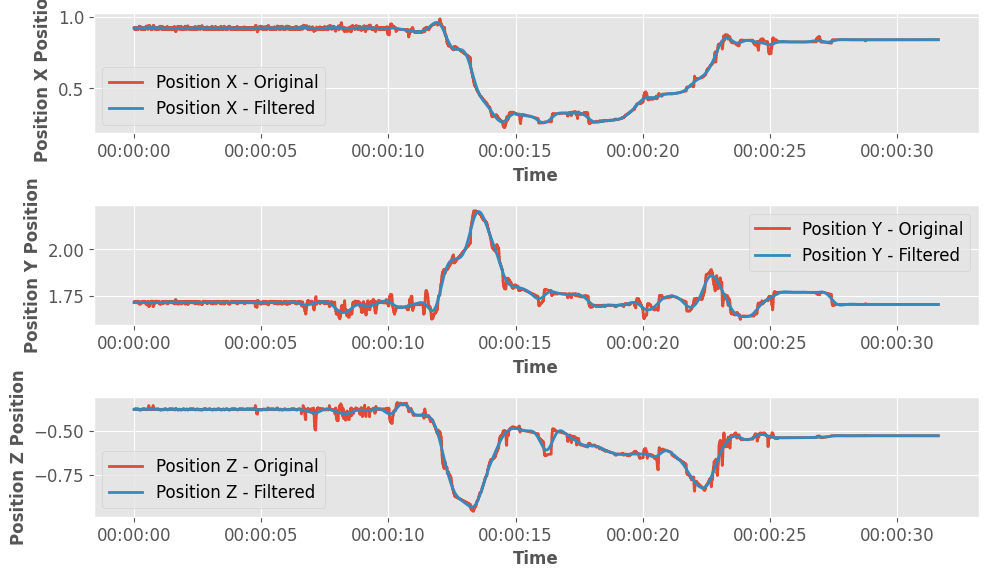

In [13]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt


mocap_pos_df = synchronized_data[['Position X', 'Position Y', 'Position Z']]
mocap_pos_filtered_df = mocap_pos_df.copy()
num_samples = len(mocap_pos_filtered_df)
# Set the cutoff frequency and filter order
cutoff_frequency = 40.0  # Adjust cutoff frequency as needed (too small try to increase)
filter_order = 4  # Adjust filter order as needed

# Normalize the cutoff frequency
normalized_cutoff = cutoff_frequency / (0.5 * num_samples)

# Apply filtering to each dimension (X, Y, Z) separately in the DataFrame
for col in mocap_pos_df.columns:
    mocap_pos_filtered_df[f'{col}'] = filtfilt(*butter(filter_order, normalized_cutoff, btype='low', analog=False), mocap_pos_df[col])


# Concat filtered positions to synchronised data
synchronized_data_filtered[mocap_pos_filtered_df.columns] = mocap_pos_filtered_df
# Plot the original and filtered signals for each dimension
plt.figure(figsize=(10, 6))

for i, col in enumerate(mocap_pos_df.columns):
    plt.subplot(3, 1, i + 1)
    plt.plot(mocap_pos_df[col], label=f'{col} - Original')
    plt.plot(synchronized_data_filtered[f'{col}'], label=f'{col} - Filtered')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Position')
    plt.legend()

plt.tight_layout()
plt.show()


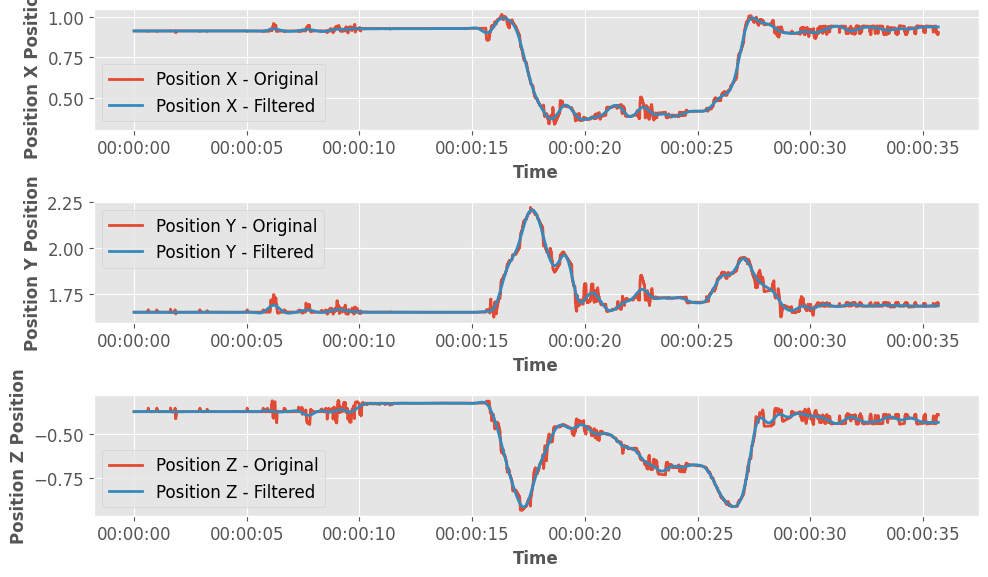

In [14]:
### TEST DATA
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt


mocap_pos_df_9 = synchronized_data_9[['Position X', 'Position Y', 'Position Z']]
mocap_pos_filtered_df_9 = mocap_pos_df_9.copy()
num_samples = len(mocap_pos_filtered_df_9)
# Set the cutoff frequency and filter order
cutoff_frequency = 40.0  # Adjust cutoff frequency as needed (too small try to increase)
filter_order = 4  # Adjust filter order as needed

# Normalize the cutoff frequency
normalized_cutoff = cutoff_frequency / (0.5 * num_samples)

# Apply filtering to each dimension (X, Y, Z) separately in the DataFrame
for col in mocap_pos_df_9.columns:
    mocap_pos_filtered_df_9[f'{col}'] = filtfilt(*butter(filter_order, normalized_cutoff, btype='low', analog=False), mocap_pos_df_9[col])


# Concat filtered positions to synchronised data
synchronized_data_filtered_9[mocap_pos_filtered_df_9.columns] = mocap_pos_filtered_df_9
# Plot the original and filtered signals for each dimension
plt.figure(figsize=(10, 6))

for i, col in enumerate(mocap_pos_df_9.columns):
    plt.subplot(3, 1, i + 1)
    plt.plot(mocap_pos_df_9[col], label=f'{col} - Original')
    plt.plot(synchronized_data_filtered_9[f'{col}'], label=f'{col} - Filtered')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Position')
    plt.legend()

plt.tight_layout()
plt.show()


### Filtering Rotation Euler using butter-worth filter

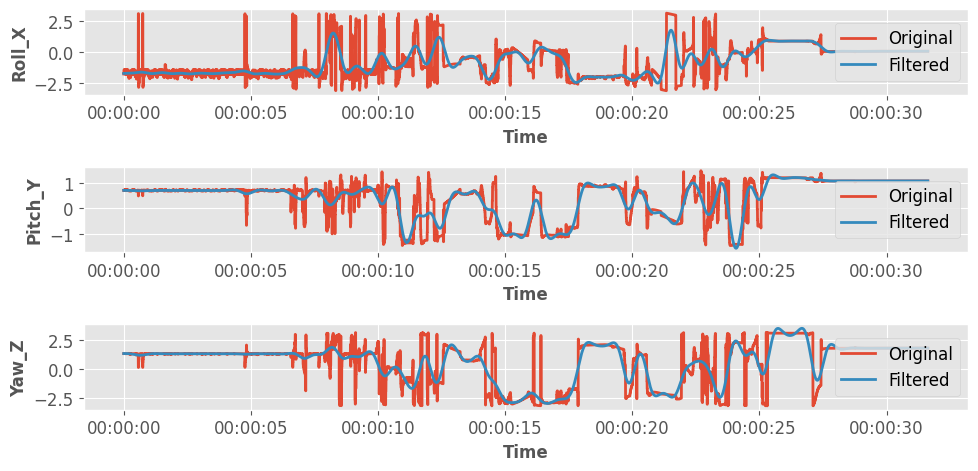

In [15]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

quaternion_df = synchronized_data[['Roll_X', 'Pitch_Y', 'Yaw_Z']]
quaternion_df_filtered = quaternion_df.copy()
num_samples = len(quaternion_df_filtered)
# Set the cutoff frequency and filter order
cutoff_frequency = 40.0  # Adjust cutoff frequency as needed (too small try to increase)
filter_order = 4  # Adjust filter order as needed

# Normalize the cutoff frequency
normalized_cutoff = cutoff_frequency / (0.5 * num_samples)

# Apply filtering to each dimension (Roll_X, Pitch_Y, Yaw_Z) separately in the DataFrame
for col in quaternion_df.columns:
    quaternion_df_filtered[f'{col}'] = filtfilt(*butter(filter_order, normalized_cutoff, btype='low', analog=False), quaternion_df[col])


# quaternion_df_filtered = pd.DataFrame(filtered_signal, columns = quaternion_df.columns)
synchronized_data_filtered[quaternion_df_filtered.columns] = quaternion_df_filtered.values

# Plot original and filtered signals for each component
plt.figure(figsize=(10, 6))
for i, comp in enumerate(quaternion_df_filtered.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(quaternion_df[comp], label='Original')
    plt.plot(synchronized_data_filtered[comp], label='Filtered')
    plt.xlabel('Time')
    plt.ylabel(f'{comp}')
    plt.legend(loc='right')
plt.tight_layout()
plt.show()


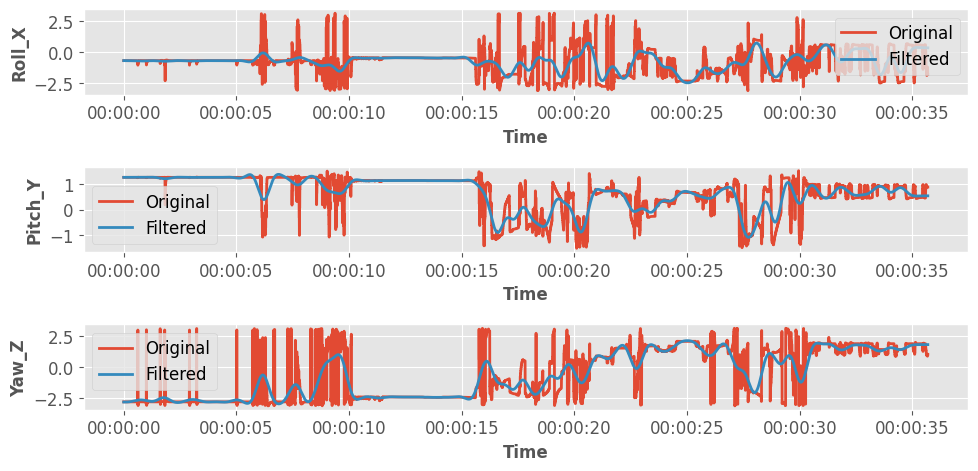

In [16]:
### TEST DATA
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

quaternion_df_9 = synchronized_data_9[['Roll_X', 'Pitch_Y', 'Yaw_Z']]
quaternion_df_filtered_9 = quaternion_df_9.copy()
num_samples = len(quaternion_df_filtered_9)
# Set the cutoff frequency and filter order
cutoff_frequency = 40.0  # Adjust cutoff frequency as needed (too small try to increase)
filter_order = 4  # Adjust filter order as needed

# Normalize the cutoff frequency
normalized_cutoff = cutoff_frequency / (0.5 * num_samples)

# Apply filtering to each dimension (Roll_X, Pitch_Y, Yaw_Z) separately in the DataFrame
for col in quaternion_df_9.columns:
    quaternion_df_filtered_9[f'{col}'] = filtfilt(*butter(filter_order, normalized_cutoff, btype='low', analog=False), quaternion_df_9[col])


# quaternion_df_filtered = pd.DataFrame(filtered_signal, columns = quaternion_df.columns)
synchronized_data_filtered_9[quaternion_df_filtered_9.columns] = quaternion_df_filtered_9.values

# Plot original and filtered signals for each component
plt.figure(figsize=(10, 6))
for i, comp in enumerate(quaternion_df_filtered_9.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(quaternion_df_9[comp], label='Original')
    plt.plot(synchronized_data_filtered_9[comp], label='Filtered')
    plt.xlabel('Time')
    plt.ylabel(f'{comp}')
    plt.legend()
plt.tight_layout()
plt.show()


In [87]:
flitered_vel = get_cartesian_velocities(synchronized_data_filtered)
flitered_vel

len delta_x = 221335 	 len delta_t = 221335


,Vel_X,Vel_Y,Vel_Z
0,-1.062870e-06,8.164138e-07,-9.090012e-08
1,-1.062586e-06,8.160334e-07,-9.091873e-08
2,-1.062019e-06,8.152720e-07,-9.095578e-08
3,-1.061450e-06,8.145094e-07,-9.099248e-08
4,-1.060880e-06,8.137458e-07,-9.102884e-08
...,...,...,...
221331,2.020597e-14,-3.095288e-13,5.839747e-14
221332,2.264845e-14,-2.837717e-13,4.307646e-14
221333,2.398071e-14,-2.575706e-13,2.997589e-14
221334,2.464684e-14,-2.309253e-13,1.909575e-14


In [28]:
### FOR TEST DATA
flitered_vel_9 = get_cartesian_velocities(synchronized_data_filtered_9)
flitered_vel_9

len delta_x = 249755 	 len delta_t = 249755


,Vel_X,Vel_Y,Vel_Z
0,-5.004963e-08,-9.730825e-08,-1.553883e-08
1,-5.004950e-08,-9.729651e-08,-1.547641e-08
2,-5.004923e-08,-9.727300e-08,-1.535151e-08
3,-5.004895e-08,-9.724942e-08,-1.522647e-08
4,-5.004866e-08,-9.722578e-08,-1.510130e-08
...,...,...,...
249751,7.447346e-13,5.195823e-14,-1.961756e-13
249752,6.310482e-13,2.087211e-14,-1.630911e-13
249753,5.295743e-13,-3.552699e-15,-1.342254e-13
249754,4.398686e-13,-2.220437e-14,-1.092455e-13


In [29]:
plt.figure(figsize=(10,6))
x = np.linspace(0,30,len(synchronized_data_filtered))
for i, c in enumerate(flitered_vel):
    plt.subplot(3,1,i+1)
    plt.plot(x, flitered_vel[c], label=f'{c}', color='k')
    plt.xlabel('time[sec]')
    plt.ylabel(f'{c} [m/s]')
    plt.tight_layout()

NameError: name 'flitered_vel' is not defined

<Figure size 1000x600 with 0 Axes>

### Filtering velocities (TODO: Final step)

In [25]:
synchronized_data_filtered[flitered_vel.columns] = flitered_vel.values
synchronized_data_filtered

,Position X,Position Y,Position Z,Roll_X,Pitch_Y,Yaw_Z,Vel_X,Vel_Y,Vel_Z,Fx,Fy,Fz,Tx,Ty,Tz
2023-01-01 00:00:00.000000000,0.919971,1.714286,-0.378645,-1.739255,0.708640,1.339969,-1.062870e-06,8.164138e-07,-9.090012e-08,55.000000,57.000000,38.000000,81.000000,18.000000,6.000000
2023-01-01 00:00:00.000142860,0.919969,1.714287,-0.378645,-1.739244,0.708640,1.339974,-1.062586e-06,8.160334e-07,-9.091873e-08,54.999200,56.999400,38.001000,80.999800,18.000200,6.000200
2023-01-01 00:00:00.000285720,0.919968,1.714288,-0.378645,-1.739234,0.708640,1.339979,-1.062019e-06,8.152720e-07,-9.095578e-08,54.999600,57.000200,37.999800,80.999600,18.000400,6.001200
2023-01-01 00:00:00.000428580,0.919967,1.714289,-0.378645,-1.739223,0.708640,1.339984,-1.061450e-06,8.145094e-07,-9.099248e-08,54.999200,57.000000,37.998200,80.998800,18.000400,6.002599
2023-01-01 00:00:00.000571440,0.919966,1.714290,-0.378645,-1.739212,0.708640,1.339989,-1.060880e-06,8.137458e-07,-9.102884e-08,54.999200,57.000200,37.997001,80.999000,18.000400,6.002799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01 00:00:31.619346660,0.838318,1.702474,-0.527704,0.057961,1.080295,1.803754,2.020597e-14,-3.095288e-13,5.839747e-14,56.469753,57.967970,34.934076,82.636509,17.606659,9.714226
2023-01-01 00:00:31.619489520,0.838318,1.702474,-0.527704,0.057961,1.080295,1.803754,2.264845e-14,-2.837717e-13,4.307646e-14,56.470859,57.968376,34.933689,82.636781,17.605938,9.714283
2023-01-01 00:00:31.619632380,0.838318,1.702474,-0.527704,0.057961,1.080295,1.803754,2.398071e-14,-2.575706e-13,2.997589e-14,56.471765,57.968383,34.933103,82.637054,17.605817,9.714540
2023-01-01 00:00:31.619775240,0.838318,1.702474,-0.527704,0.057961,1.080295,1.803754,2.464684e-14,-2.309253e-13,1.909575e-14,56.471871,57.969389,34.932916,82.637327,17.606296,9.714397


In [41]:
synchronized_data_filtered_9[flitered_vel.columns] = flitered_vel_9.values
synchronized_data_filtered_9

,Position X,Position Y,Position Z,Roll_X,Pitch_Y,Yaw_Z,Fx,Fy,Fz,Tx,Ty,Tz,Vel_X,Vel_Y,Vel_Z
2023-01-01 00:00:00.000000000,0.912231,1.651056,-0.371990,-0.702803,1.270349,-2.830508,52.000000,54.000000,35.000000,80.000000,17.000000,9.000000,-5.004963e-08,-9.730825e-08,-1.553883e-08
2023-01-01 00:00:00.000142860,0.912231,1.651056,-0.371990,-0.702803,1.270349,-2.830515,52.001400,54.000400,34.999800,80.000200,17.000200,9.000400,-5.004950e-08,-9.729651e-08,-1.547641e-08
2023-01-01 00:00:00.000285720,0.912231,1.651056,-0.371990,-0.702802,1.270349,-2.830521,52.001800,54.000600,34.999000,80.000400,17.000600,9.001000,-5.004923e-08,-9.727300e-08,-1.535151e-08
2023-01-01 00:00:00.000428580,0.912231,1.651056,-0.371990,-0.702802,1.270348,-2.830527,52.002399,54.001000,34.999200,80.000800,17.000800,9.001200,-5.004895e-08,-9.724942e-08,-1.522647e-08
2023-01-01 00:00:00.000571440,0.912231,1.651056,-0.371990,-0.702801,1.270348,-2.830534,52.003799,54.001399,34.999200,80.000600,17.000600,9.002399,-5.004866e-08,-9.722578e-08,-1.510130e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01 00:00:35.679427860,0.937170,1.685941,-0.433039,0.331211,0.546906,1.816501,56.716730,55.539723,34.032153,79.975702,17.248290,10.176893,7.447346e-13,5.195823e-14,-1.961756e-13
2023-01-01 00:00:35.679570720,0.937170,1.685941,-0.433039,0.331211,0.546906,1.816501,56.716387,55.539215,34.031747,79.975707,17.248840,10.177457,6.310482e-13,2.087211e-14,-1.630911e-13
2023-01-01 00:00:35.679713580,0.937170,1.685941,-0.433039,0.331211,0.546906,1.816501,56.716443,55.539707,34.031141,79.975712,17.248190,10.177022,5.295743e-13,-3.552699e-15,-1.342254e-13
2023-01-01 00:00:35.679856440,0.937170,1.685941,-0.433039,0.331211,0.546906,1.816501,56.716100,55.539799,34.030734,79.975717,17.248741,10.176986,4.398686e-13,-2.220437e-14,-1.092455e-13


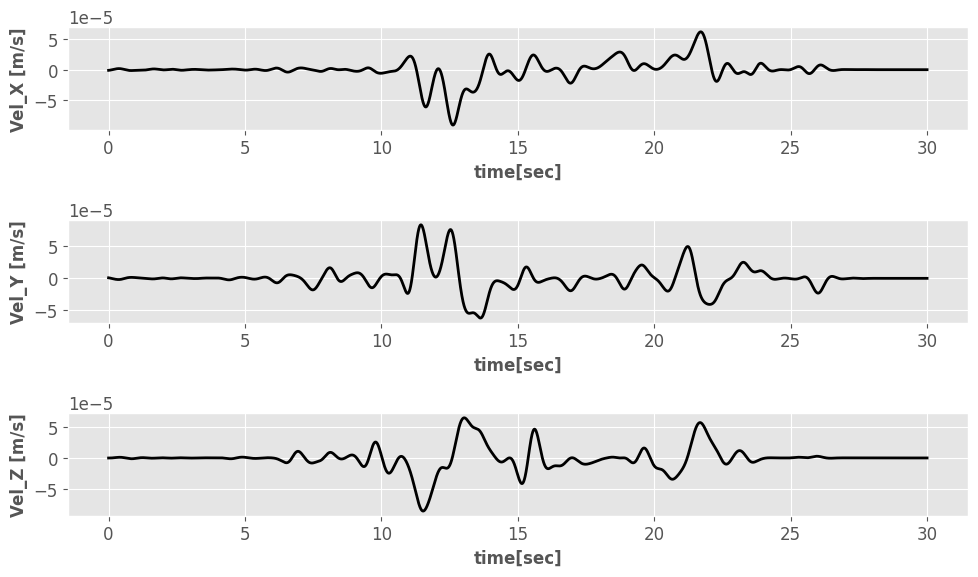

In [26]:
plt.figure(figsize=(10,6))
x = np.linspace(0,30,len(synchronized_data_filtered))
for i, c in enumerate(flitered_vel):
    plt.subplot(3,1,i+1)
    plt.plot(x, synchronized_data_filtered[c], label=f'{c}', color='k')
    plt.xlabel('time[sec]')
    plt.ylabel(f'{c} [m/s]')
    plt.tight_layout()

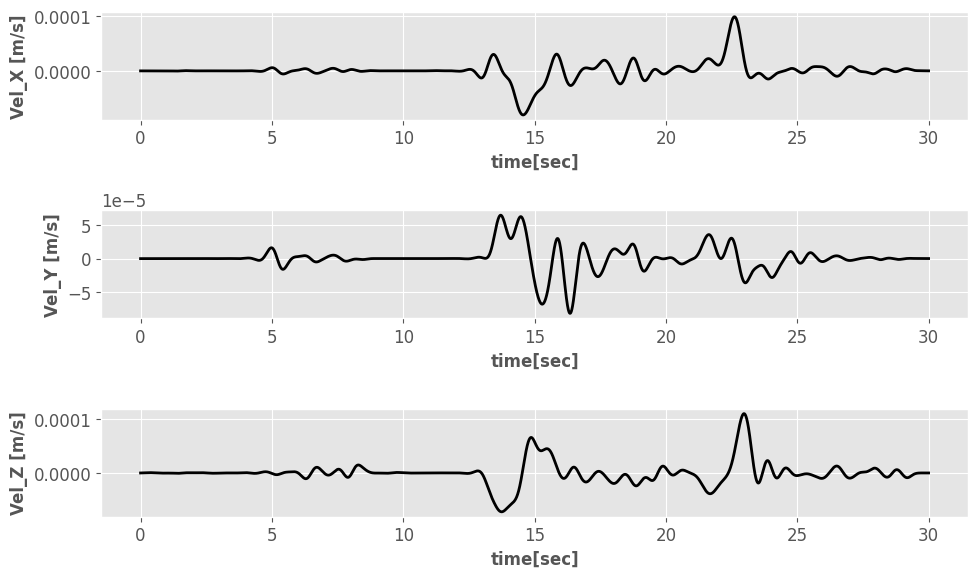

In [42]:
### FOR TEST DATA
plt.figure(figsize=(10,6))
x = np.linspace(0,30,len(synchronized_data_filtered_9))
for i, c in enumerate(flitered_vel_9):
    plt.subplot(3,1,i+1)
    plt.plot(x, synchronized_data_filtered_9[c], label=f'{c}', color='k')
    plt.xlabel('time[sec]')
    plt.ylabel(f'{c} [m/s]')
    plt.tight_layout()

In [ ]:
# Save the resulted synchronized filtered data
synchronized_data_filtered.to_csv('/content/mocap_ft_mat2_ex1_trial10.csv')

#### Visualuze positions

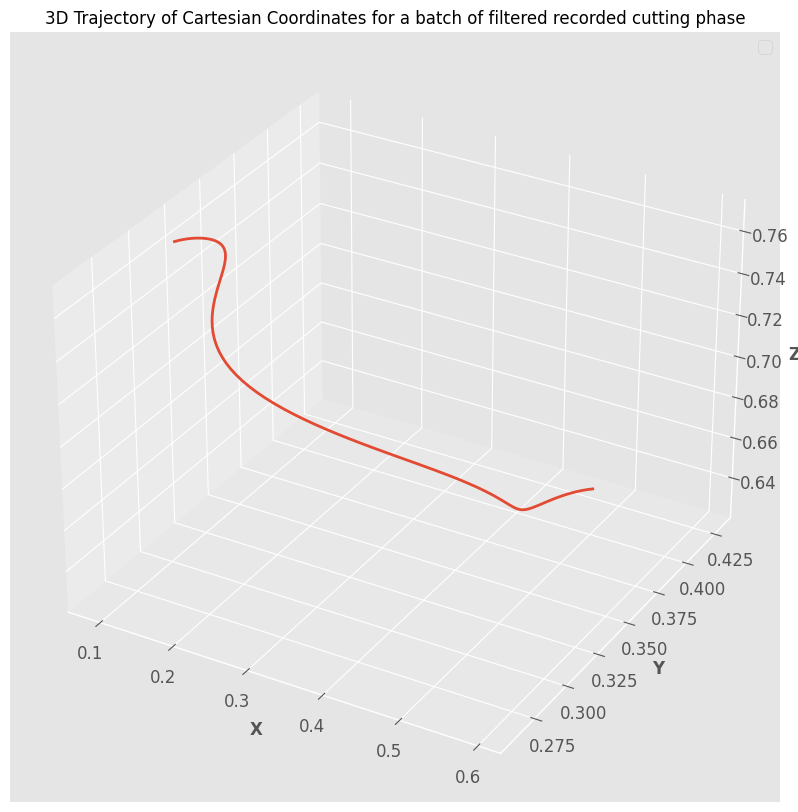

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Plot the trajectories in 3D for original and filtered coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Original coordinates
ax.plot(mocap_pos_filtered_df['Position X'][1400:1500], mocap_pos_filtered_df['Position Y'][1400:1500], mocap_pos_filtered_df['Position Z'][1400:1500])

# # Filtered coordinates
# ax.plot(df['Filtered_X'], df['Filtered_Y'], df['Filtered_Z'], label='Filtered Trajectory')

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory of Cartesian Coordinates for a batch of filtered recorded cutting phase')

# Display legend
ax.legend()

plt.show()


In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
# from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
from sklearn.mixture.tests.test_gaussian_mixture import _compute_precision_cholesky
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from pprint import pprint

class GMM_GMR:
  def __init__(self, n_components: int = 50) -> None:
     self._n_components = n_components
     self.gmm = GaussianMixture(n_components=self._n_components)
     self.gmr = LinearRegression()
     self.MSE = np.inf
     self.R2 = 0
  def _save_GMM(self, path):
    assert path.split('.')[-1] == "pkl", "The GMM model should be saved in pkl format"
    joblib.dump(self.gmm, path)

  def _load_GMM(self, path):
    assert path.split('.')[-1] == "pkl", "The GMM model path should refer a pikle file"
    self.gmm = joblib.load(path)

  def _save_GMR(self, path):
    assert path.split('.')[-1] == "pkl", "The GMR model should be saved in pkl format"
    joblib.dump(self.gmr, path)

  def _load_GMR(self, path):
    assert path.split('.')[-1] == "pkl", "The GMR model path should refer a pikle file"
    self.gmr = joblib.load(path)

  def model_fit(self, X_train, y_train, pretrained = False):

    if not pretrained:
      # Get posterior probabilities for GMR on training set
      self.gmm.fit(X_train)
      posterior_probs_train = self.gmm.predict_proba(X_train)
      weighted_samples_train = self.gmm.predict(X_train).reshape(-1, 1) * posterior_probs_train / np.sum(posterior_probs_train, axis=1).reshape(-1, 1)

      # Training GMR
      self.gmr.fit(weighted_samples_train, y_train)
      # Evaluate GMR model
      # mse = self.evaluate(X_train, y_train, mode="train")
    else:
      pass
    return weighted_samples_train

  def evaluate(self, X, y, mode="val"):
    assert mode in ["train","val","test"], "The mode should be one of: train, val, test !"
    # Get posterior probabilities for validation set
    # posterior_probs = self.gmm.predict_proba(X)
    # weighted_samples = self.gmm.predict(X).reshape(-1, 1) * posterior_probs / np.sum(posterior_probs, axis=1).reshape(-1, 1)
    weighted_samples = self.model_fit(X,y)
    # Predict on validation set
    y_pred = self.gmr.predict(weighted_samples)

    # Evaluate GMR model on validation set
    mse = mean_squared_error(y, y_pred)
    print(f"{mode} MSE loss: {mse}")
    # print(f"mse_{mode} loss: {mse} \t r2_{mode} metric:{r2}")
    # return mse, r2
    return mse

  def train(self, X_train, y_train, X_val, y_val, n_epochs=10):
    for E in range(n_epochs):
      pprint(f"Epoch {E}:")
      mse_train = self.evaluate(X_train, y_train, mode="train")
      mse_val = self.evaluate(X_val, y_val, mode = "val")


  def pred(self, new_time_data):
    posterior_probs = self.gmm.predict_proba(new_time_data)
    weighted_samples = self.gmm.predict(new_time_data).reshape(-1, 1) * posterior_probs / np.sum(posterior_probs, axis=1).reshape(-1, 1)
    y_pred = self.gmr.predict(weighted_samples)
    return y_pred

    # predicted_clusters = self.gmm.predict(new_time_data)
    # new_posterior_probs = self.gmm.predict_proba(new_time_data)
    # new_weighted_samples = _compute_precision_cholesky(self.gmm.covariances_, 'full') @ new_posterior_probs.T
    # predicted_features = self.gmr.predict(new_weighted_samples.T)







# # Generating synthetic data (time and output data)
# np.random.seed(42)
# time = np.linspace(0, 10, 100)[:, np.newaxis]  # Time data
# output_data = np.sin(time).ravel() + 0.3 * np.random.randn(100)  # Synthetic output data

# n_comps = [int (c) for c in np.linspace(5,50,10)]

# plt.figure(figsize=(8, 6))
# plt.scatter(time, output_data, label='Original Data', color='blue')
# for c in n_comps:
#   # Training GMM
#   gmm = GaussianMixture(n_components=c)
#   gmm.fit(time)

#   # Get posterior probabilities
#   posterior_probs = gmm.predict_proba(time)

#   # Train GMR
#   gmr = LinearRegression()
#   gmr.fit(posterior_probs, output_data)

#   # Generate new time data for prediction
#   new_time_data = np.linspace(0, 10, 200)[:, np.newaxis]

#   # Predict using GMR
#   predicted_output = gmr.predict(gmm.predict_proba(new_time_data))

#   # Plotting original and predicted data

#   plt.plot(new_time_data, predicted_output, label=f'Predicted Data (n cmops = {c})')

# plt.xlabel('Time')
# plt.ylabel('Output')
# plt.title('GMR Prediction')
# plt.legend()
# plt.show()


In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
# from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
from sklearn.mixture.tests.test_gaussian_mixture import _compute_precision_cholesky
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from pprint import pprint

class GMM_GMR_NEW:
  def __init__(self, n_components: int = 5) -> None:
     self._n_components = n_components
     self.gmm = GaussianMixture(n_components=self._n_components)
     self.gmr = LinearRegression()
     self.MSE = np.inf
     self.R2 = 0
  def _save_GMM(self, path):
    assert path.split('.')[-1] == "pkl", "The GMM model should be saved in pkl format"
    joblib.dump(self.gmm, path)

  def _load_GMM(self, path):
    assert path.split('.')[-1] == "pkl", "The GMM model path should refer a pikle file"
    self.gmm = joblib.load(path)

  def _save_GMR(self, path):
    assert path.split('.')[-1] == "pkl", "The GMR model should be saved in pkl format"
    joblib.dump(self.gmr, path)

  def _load_GMR(self, path):
    assert path.split('.')[-1] == "pkl", "The GMR model path should refer a pikle file"
    self.gmr = joblib.load(path)

  def model_fit(self, X_train, y_train, X_test, y_test, pretrained = False):

    if not pretrained:
      # Train a Gaussian Mixture Model (GMM) on the output variables
      self.gmm.fit(y_train)

      # Calculate posterior probabilities for GMM predictions
      posterior_probs_train = self.gmm.predict_proba(y_train)

      # Weighted samples based on GMM predictions
      weighted_samples_train = self.gmm.predict(y_train).reshape(-1, 1) * posterior_probs_train / np.sum(posterior_probs_train, axis=1).reshape(-1, 1)

      # Training GMR using the weighted samples and Kernel Density Estimation (KDE)
      gmr_predictions = []
      for i, sample in enumerate(weighted_samples_train):
          means = self.gmm.means_
          covariances = self.gmm.covariances_
          n_components = len(means)
          y_pred_component = np.zeros(y_train.shape[1])  # Dimension of output variables
          kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.linspace(-5, 5, 100).reshape(-1, 1))
          kde_scores = np.exp(kde.score_samples(np.linspace(-5, 5, 100).reshape(-1, 1)))
          for j in range(n_components):
              mean = means[j]
              covariance = covariances[j]
              y_pred_component += sample[j] * kde_scores[j] * mean
          gmr_predictions.append(y_pred_component)
          y_pred = np.array(gmr_predictions)
          mse = mean_squared_error(y_train, y_pred)
    else:
      pass
    return mse

  def train(self, X_train, y_train, X_test, y_test, n_epochs=10):
    for E in range(n_epochs):
      pprint(f"Epoch {E}:")
      mse = self.model_fit(X_train, y_train, X_test, y_test)


  def pred(self, new_time_data):
    y_pred = self.gmr.predict(self.gmm.predict_proba(new_time_data))
    return y_pred


In [ ]:
# import numpy as np
# from sklearn.mixture import GaussianMixture
# # from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
# from sklearn.mixture.tests.test_gaussian_mixture import _compute_precision_cholesky
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split
# import joblib
# import matplotlib.pyplot as plt
# from pprint import pprint

# class GMM_GMR:
#   def __init__(self, n_components: int = 5) -> None:
#      self._n_components = n_components
#      self.gmm = GaussianMixture(n_components=self._n_components)
#      self.gmr = LinearRegression()
#      self.MSE = np.inf
#      self.R2 = 0
#   def _save_GMM(self, path):
#     assert path.split('.')[-1] == "pkl", "The GMM model should be saved in pkl format"
#     joblib.dump(self.gmm, path)

#   def _load_GMM(self, path):
#     assert path.split('.')[-1] == "pkl", "The GMM model path should refer a pikle file"
#     self.gmm = joblib.load(path)

#   def _save_GMR(self, path):
#     assert path.split('.')[-1] == "pkl", "The GMR model should be saved in pkl format"
#     joblib.dump(self.gmr, path)

#   def _load_GMR(self, path):
#     assert path.split('.')[-1] == "pkl", "The GMR model path should refer a pikle file"
#     self.gmr = joblib.load(path)

#   def model_fit(self, X_train, y_train, pretrained = False):

#     if not pretrained:
#       # Get posterior probabilities for GMR on training set
#       self.gmm.fit(X_train)
#       posterior_probs_train = self.gmm.predict_proba(y_train)
#       weighted_samples_train = self.gmm.predict(y_train).reshape(-1, 1) * posterior_probs_train / np.sum(posterior_probs_train, axis=1).reshape(-1, 1)

#       # Training GMR
#       self.gmr.fit(weighted_samples_train, y_train)
#       # Evaluate GMR model
#       # mse = self.evaluate(X_train, y_train, mode="train")
#     else:
#       pass
#     return weighted_samples_train

#   def evaluate(self, X, y, mode="val"):
#     assert mode in ["train","val","test"], "The mode should be one of: train, val, test !"
#     # Get posterior probabilities for validation set
#     # posterior_probs = self.gmm.predict_proba(X)
#     # weighted_samples = self.gmm.predict(X).reshape(-1, 1) * posterior_probs / np.sum(posterior_probs, axis=1).reshape(-1, 1)
#     weighted_samples = self.model_fit(X,y)
#     # Predict on validation set
#     y_pred = self.gmr.predict(weighted_samples)

#     # Evaluate GMR model on validation set
#     mse = mean_squared_error(y, y_pred)
#     print(f"{mode} MSE loss: {mse}")
#     # print(f"mse_{mode} loss: {mse} \t r2_{mode} metric:{r2}")
#     # return mse, r2
#     return mse

#   def train(self, X_train, y_train, X_val, y_val, n_epochs=10):
#     for E in range(n_epochs):
#       pprint(f"Epoch {E}:")
#       mse_train = self.evaluate(X_train, y_train, mode="train")
#       mse_val = self.evaluate(X_val, y_val, mode = "val")


#   def pred(self, new_time_data):
#     y_pred = self.gmr.predict(self.gmm.predict_proba(new_time_data))
#     return y_pred

Test Loss (MSE): 0.0401
Test R2 Score: -0.4689


<Figure size 800x600 with 0 Axes>

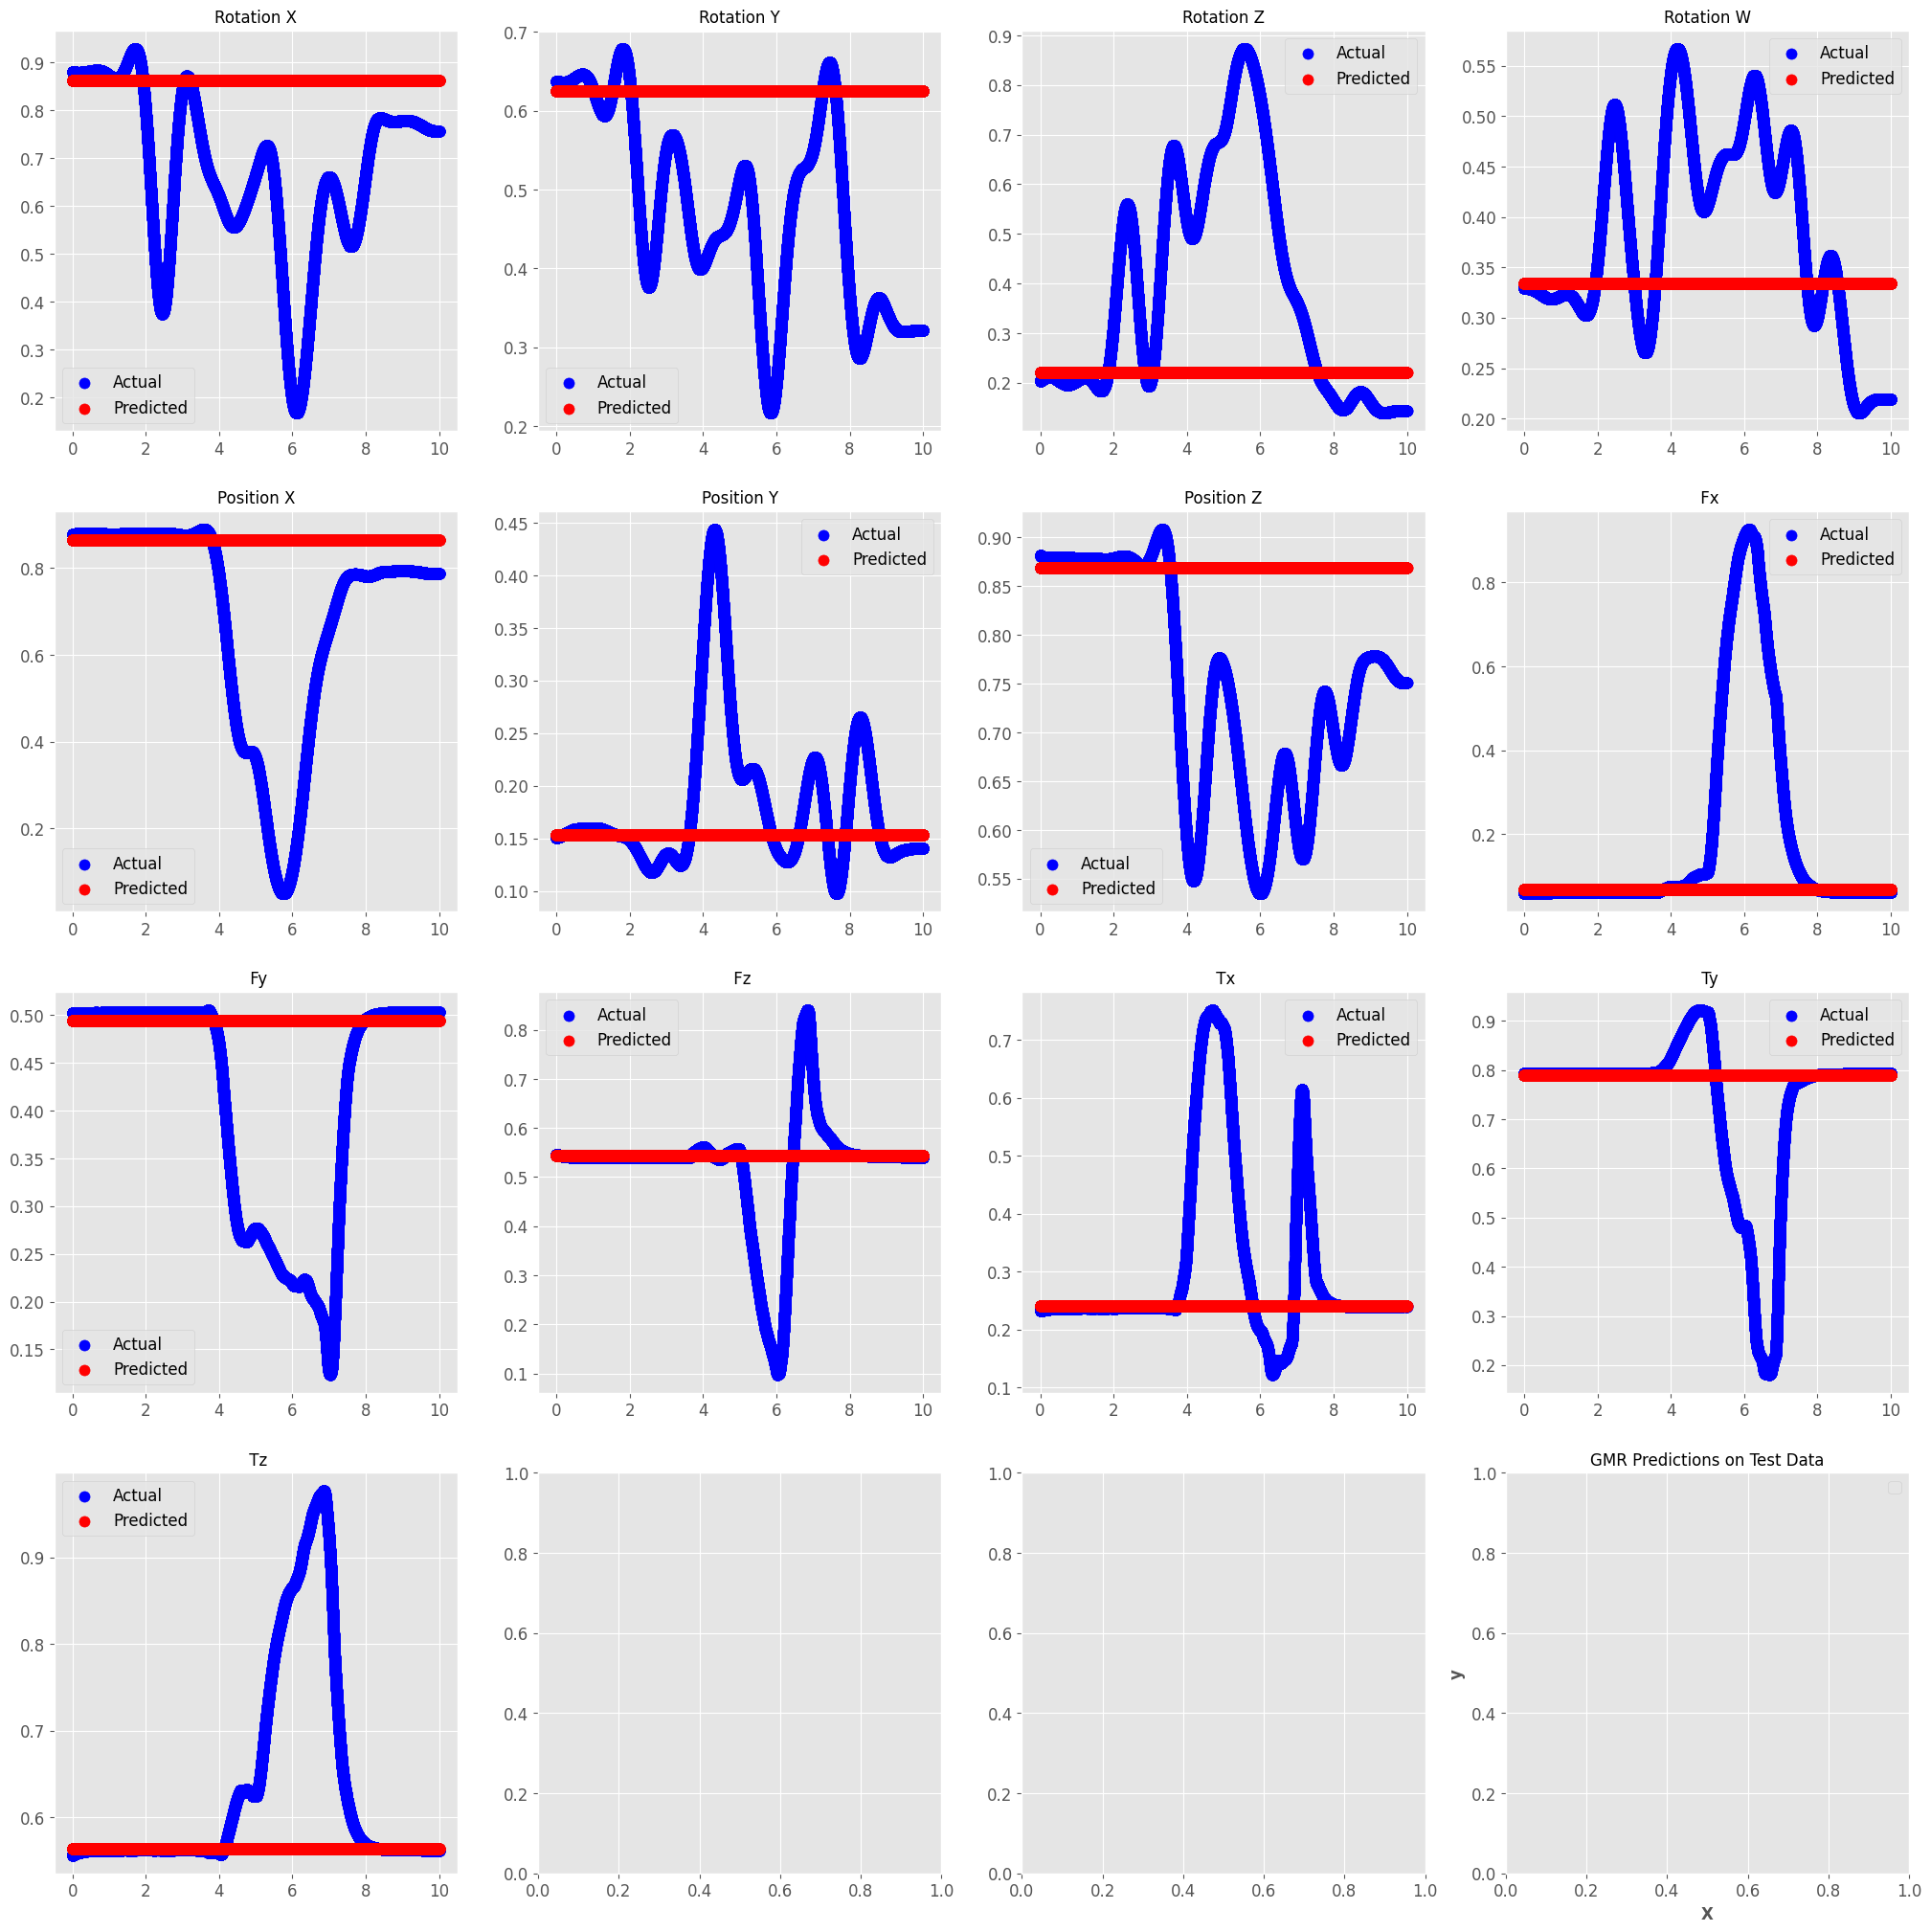

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.utils.extmath import cartesian
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming you have already trained the GMR model and obtained 'self.gmm' and 'self.gmr'

# Generate synthetic data for demonstration purposes
np.random.seed(42)
n_samples = len(synchronized_data_filtered)
X = np.linspace(0, 10, n_samples).reshape(-1, 1)
# y = np.sin(X).ravel() + np.random.normal(0, 0.2, n_samples)
y = synchronized_data_filtered
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred_test = Model.pred(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=y.columns)
# Calculate metrics (MSE and R2 score) for evaluation
test_loss = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")

# Visualize predictions on test data
plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 25))
# Flatten the axes array for easy iteration
axes = axes.flatten()
for i,c in enumerate(y_test.columns):
  ax = axes[i]
  ax.scatter(X_test, y_test[c], color='blue', label='Actual')
  ax.scatter(X_test, y_pred_test[c], color='red', label='Predicted')
  ax.set_title(c)
  ax.legend()
plt.title('GMR Predictions on Test Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


# GMM/GMR 

### Data alignment using DTW

In [17]:
import pandas as pd
from fastdtw import fastdtw
import matplotlib.pyplot as plt

def Align_using_DTW(df1, df2):
    aligned_df1 = pd.DataFrame()
    aligned_df2 = pd.DataFrame()
    # Loop through columns and perform DTW alignment using fastdtw
    for column in df1.columns:
        # Calculate DTW distance and path for each pair of columns
        distance, path = fastdtw(df1[column], df2[column])

        # Initialize aligned column lists
        aligned_column_df1 = []
        aligned_column_df2 = []

        # Align sequences based on the path for the current column
        for idx1, idx2 in path:
            aligned_column_df1.append(df1[column][idx1])
            aligned_column_df2.append(df2[column][idx2])

        # Assign aligned sequences to the aligned DataFrames
        aligned_df1[column] = pd.Series(aligned_column_df1)
        aligned_df2[column] = pd.Series(aligned_column_df2)
    return aligned_df1, aligned_df2

aligned_df1, aligned_df2 = Align_using_DTW(synchronized_data_filtered, synchronized_data_filtered_9)
aligned_df1 = aligned_df1.interpolate(method='linear')
aligned_df2 = aligned_df2.interpolate(method='linear')


C:\Users\wadda\AppData\Local\Temp\ipykernel_15588\980553045.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aligned_column_df1.append(df1[column][idx1])
C:\Users\wadda\AppData\Local\Temp\ipykernel_15588\980553045.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aligned_column_df2.append(df2[column][idx2])
C:\Users\wadda\AppData\Local\Temp\ipykernel_15588\980553045.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aligned

### Training GMR on aligned training data

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from gmr import GMM, plot_error_ellipses


scaler = MinMaxScaler()
data = scaler.fit_transform(aligned_df1)
synchronized_data_filtered_scaled_aligned = pd.DataFrame(data, columns=aligned_df1.columns)
random_state = np.random.RandomState(3)
# x = f(y, random_state)
# Set seed for reproducibility
np.random.seed(42)


x = np.linspace(0, 30, len(synchronized_data_filtered_scaled_aligned))
y= aligned_df1
XY_train = np.column_stack((x, y))
gmm = GMM(n_components=30, random_state=random_state)
gmm.from_samples(XY_train)
# y_pred = gmm.sample(len(y))
y_pred = gmm.predict(np.array([0]), x[:, np.newaxis])

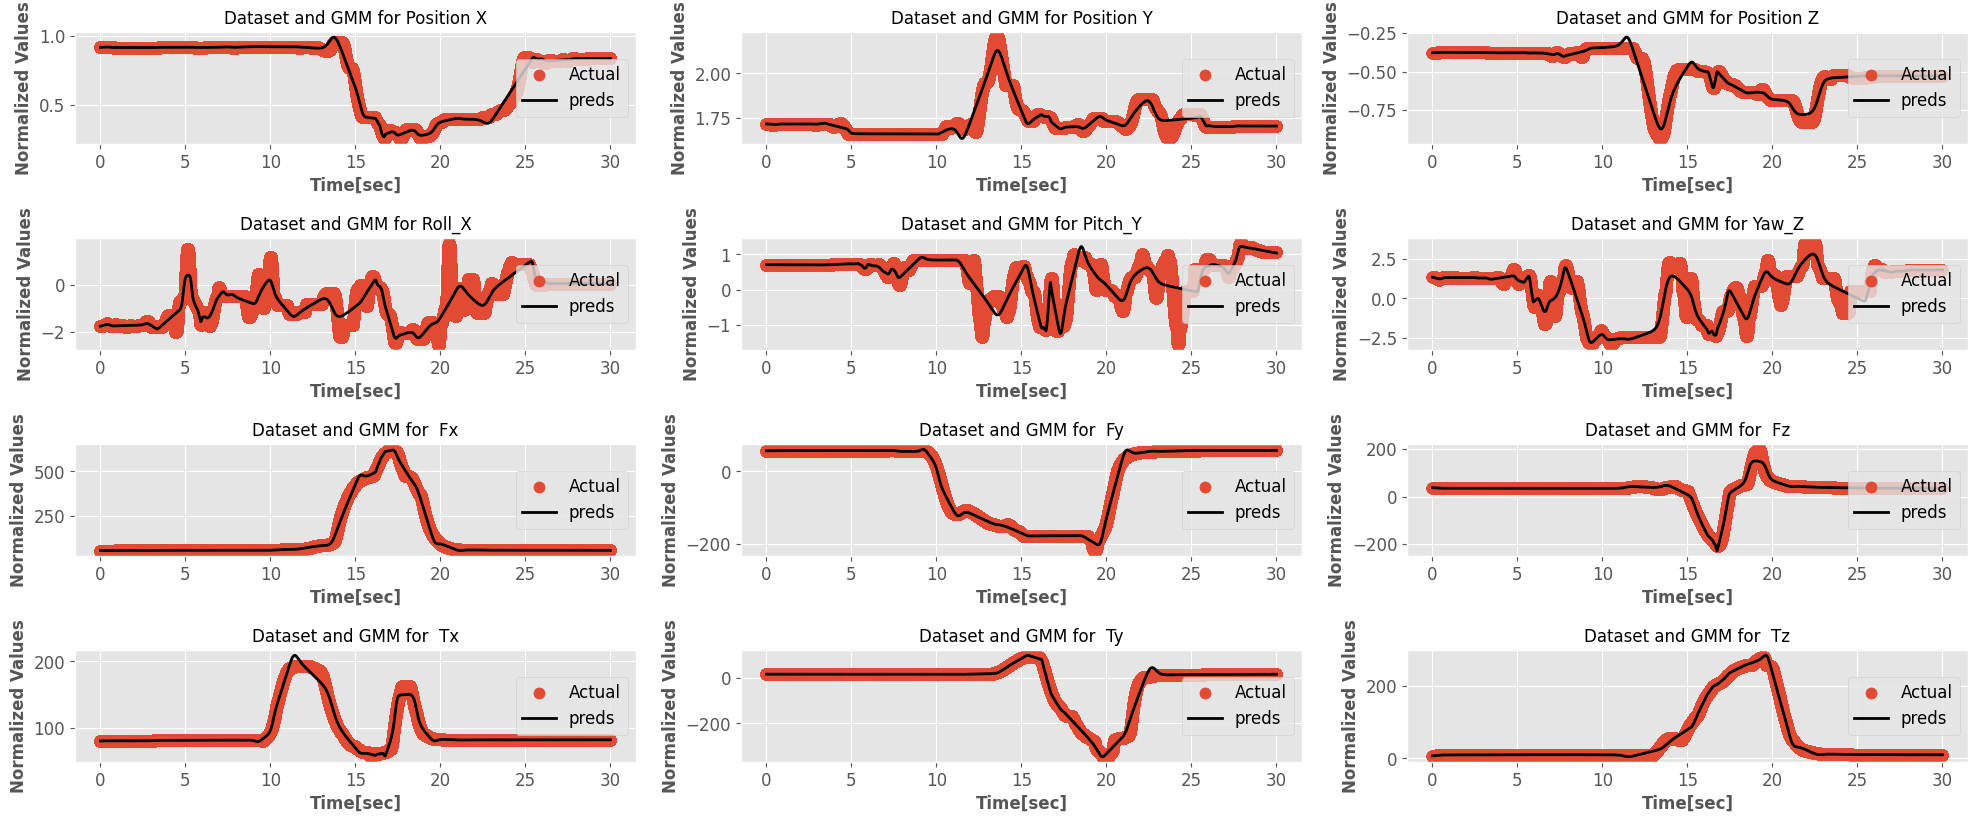

In [24]:
## ALIGNED TRAINING DATA DATA
# Create subplots for each column
plt.figure(figsize=(20, 10))

# Flatten the axes array for easy iteration
# axes = axes.flatten()

for i,c in enumerate(y.columns):
  plt.subplot(5,3,i+1)
  # ax = plt.subplot(121)
  plt.title(f"Dataset and GMM for {c}")
  # ax.scatter(x, y[:,i], label="Original")
  # ax.scatter(x, y_pred[:,i], label="preds")
  plt.scatter(x,y[c], label="Actual")
  plt.plot(x, y_pred[:,i], label="preds", color='k')


  # colors = ["r", "g", "b", "orange"]
  # plot_error_ellipses(ax, gmm, colors=colors)
  plt.xlabel("Time[sec]")
  plt.ylabel("Normalized Values")
  plt.legend(loc='right')
  plt.tight_layout()

### Testing GMR on aligned test data

In [25]:
### ALIGNED TEST DATA
import numpy as np
import matplotlib.pyplot as plt
from gmr import GMM, plot_error_ellipses


scaler = MinMaxScaler()
data = scaler.fit_transform(aligned_df2)
synchronized_data_filtered_scaled_aligned_9 = pd.DataFrame(data, columns=synchronized_data_filtered_9.columns)
random_state = np.random.RandomState(3)
# x = f(y, random_state)
# Set seed for reproducibility
np.random.seed(42)


x = np.linspace(0, 30, len(synchronized_data_filtered_scaled_aligned_9))
y= aligned_df2
# XY_train = np.column_stack((x, y))
# gmm = GMM(n_components=30, random_state=random_state)
# gmm.from_samples(XY_train)
# y_pred = gmm.sample(len(y))
y_pred = gmm.predict(np.array([0]), x[:, np.newaxis])

C:\Users\wadda\AppData\Local\Temp\ipykernel_15588\3055205459.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
d:\PhD\Mocap Force Dataset\Data preprocessing\mocap_env\Lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
d:\PhD\Mocap Force Dataset\Data preprocessing\mocap_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


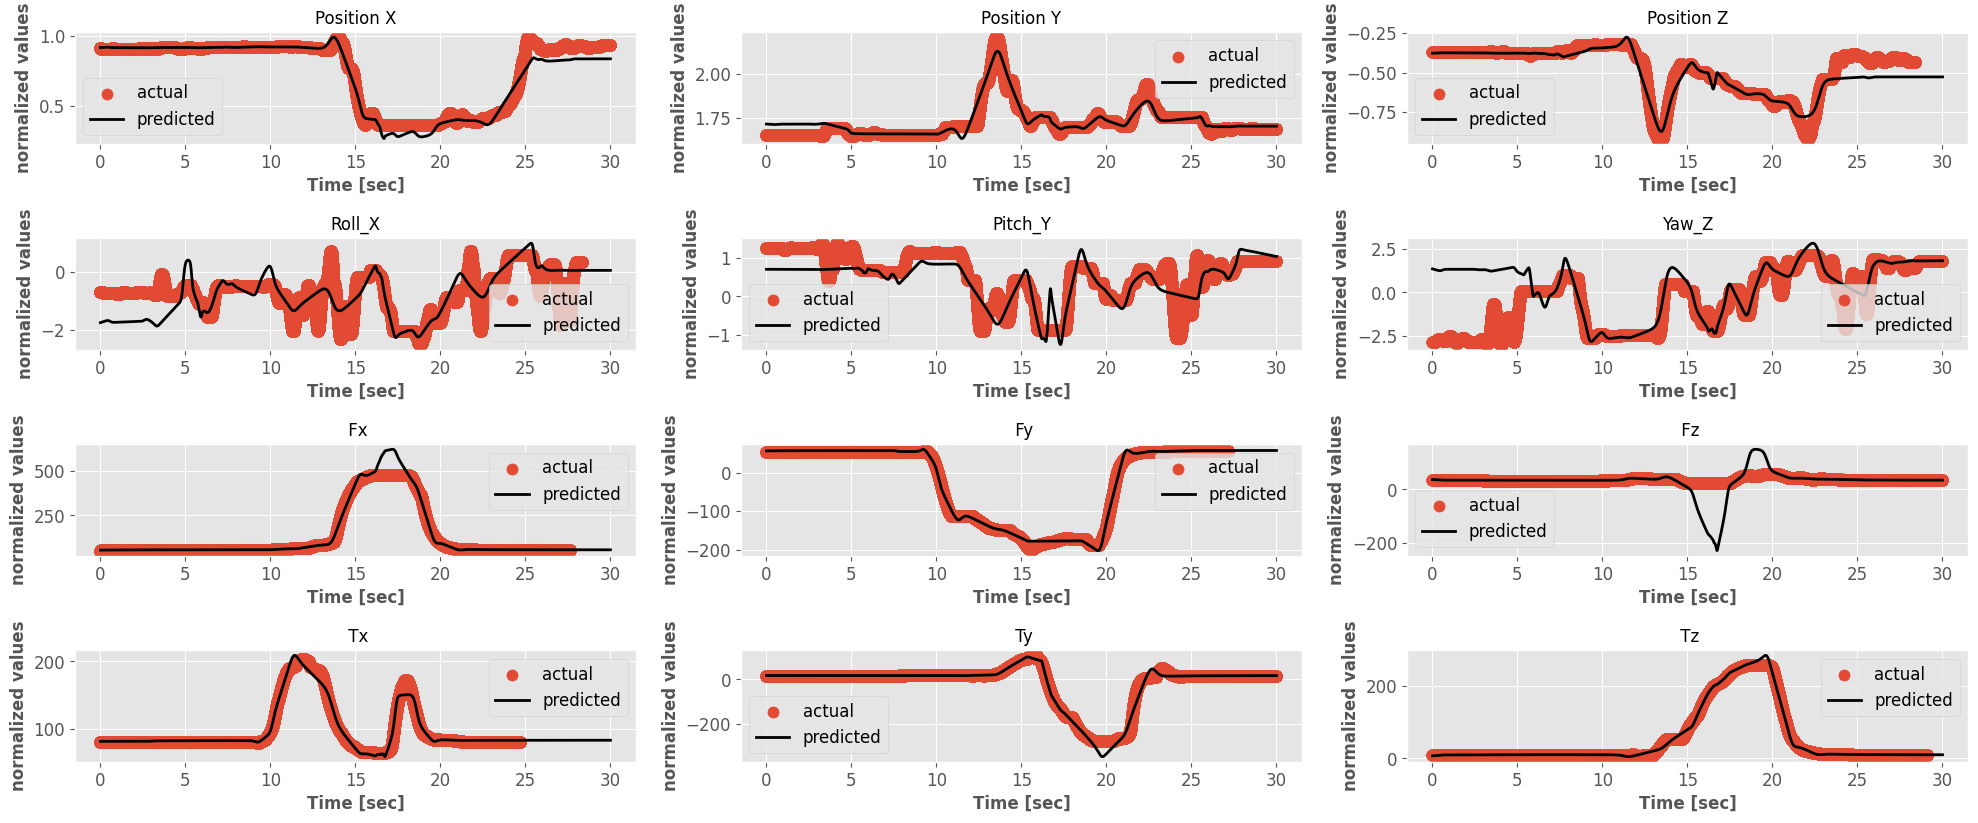

In [27]:
plt.figure(figsize=(20,10))
for i, c in enumerate(aligned_df2):
  plt.subplot(5,3,i+1)
  plt.scatter(x, aligned_df2[c], label='actual')
  plt.plot(x, y_pred[:,i], label='predicted',color='k')
  plt.xlabel('Time [sec]')
  plt.ylabel('normalized values')
  plt.title(f'{c}')
  plt.legend()
  plt.tight_layout()

### Get cartesian velociites

In [33]:
x = np.linspace(0, 30, len(aligned_df1))
y_pred = gmm.predict(np.array([0]), x[:, np.newaxis])
preds_df = pd.DataFrame(y_pred, columns=synchronized_data_filtered.columns)
preds_vel = get_cartesian_velocities(preds_df)
preds_vel
flitered_vel = get_cartesian_velocities(aligned_df1)

len delta_x = 359661 	 len delta_t = 359661
len delta_x = 359661 	 len delta_t = 359661


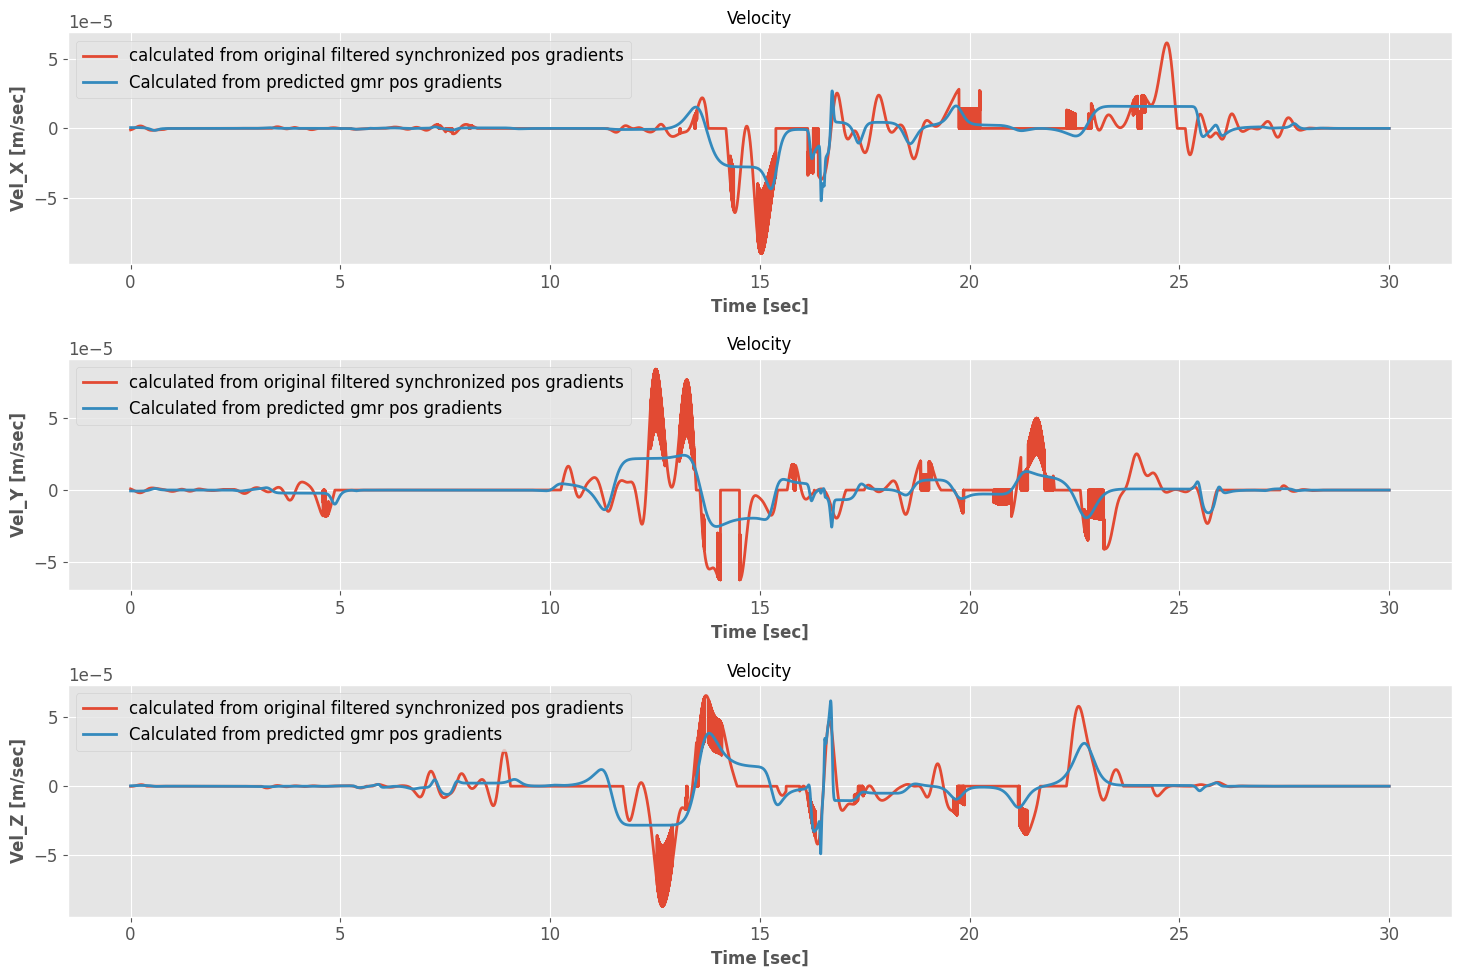

In [36]:
# preds_vel_gmr = preds_df[['Vel_X', 'Vel_Y', 'Vel_Z']]
x = np.linspace(0,30,len(preds_vel))
plt.figure(figsize=(15,10))
for i,c in enumerate(preds_vel):
    plt.subplot(3,1,i+1)
    # plt.plot(x, preds_vel_gmr[c], label='Predicted by gmr model')

    plt.plot(x, flitered_vel[c], label='calculated from original filtered synchronized pos gradients')
    plt.plot(x, preds_vel[c], label='Calculated from predicted gmr pos gradients')
    plt.legend(loc='upper left')
    plt.title('Velocity')
    plt.xlabel('Time [sec]')
    plt.ylabel(f'{c} [m/sec]')
    plt.tight_layout()

### Adding velocities to the synchronized filtered aligned mocap ft dataframe

In [39]:
aligned_df1_with_vel = aligned_df1.copy()
aligned_df1_with_vel[flitered_vel.columns] = flitered_vel.values
aligned_df1_with_vel.columns

Index(['Position X', 'Position Y', 'Position Z', 'Roll_X', 'Pitch_Y', 'Yaw_Z',
       ' Fx', ' Fy', ' Fz', ' Tx', ' Ty', ' Tz', 'Vel_X', 'Vel_Y', 'Vel_Z'],
      dtype='object')

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from gmr import GMM, plot_error_ellipses


scaler = MinMaxScaler()
data = scaler.fit_transform(aligned_df1_with_vel)
synchronized_data_filtered_scaled_aligned_with_vel = pd.DataFrame(data, columns=aligned_df1_with_vel.columns)
random_state = np.random.RandomState(3)
# x = f(y, random_state)
# Set seed for reproducibility
np.random.seed(42)


x = np.linspace(0, 30, len(synchronized_data_filtered_scaled_aligned_with_vel))
y= aligned_df1_with_vel
XY_train = np.column_stack((x, y))
gmm_with_vel = GMM(n_components=30, random_state=random_state)
gmm_with_vel.from_samples(XY_train)
# y_pred = gmm.sample(len(y))
y_pred = gmm_with_vel.predict(np.array([0]), x[:, np.newaxis])

d:\PhD\Mocap Force Dataset\Data preprocessing\mocap_env\Lib\site-packages\gmr\mvn.py:198: RuntimeWarning: overflow encountered in square
  exponent = -0.5 * np.sum(X_normalized ** 2, axis=1)


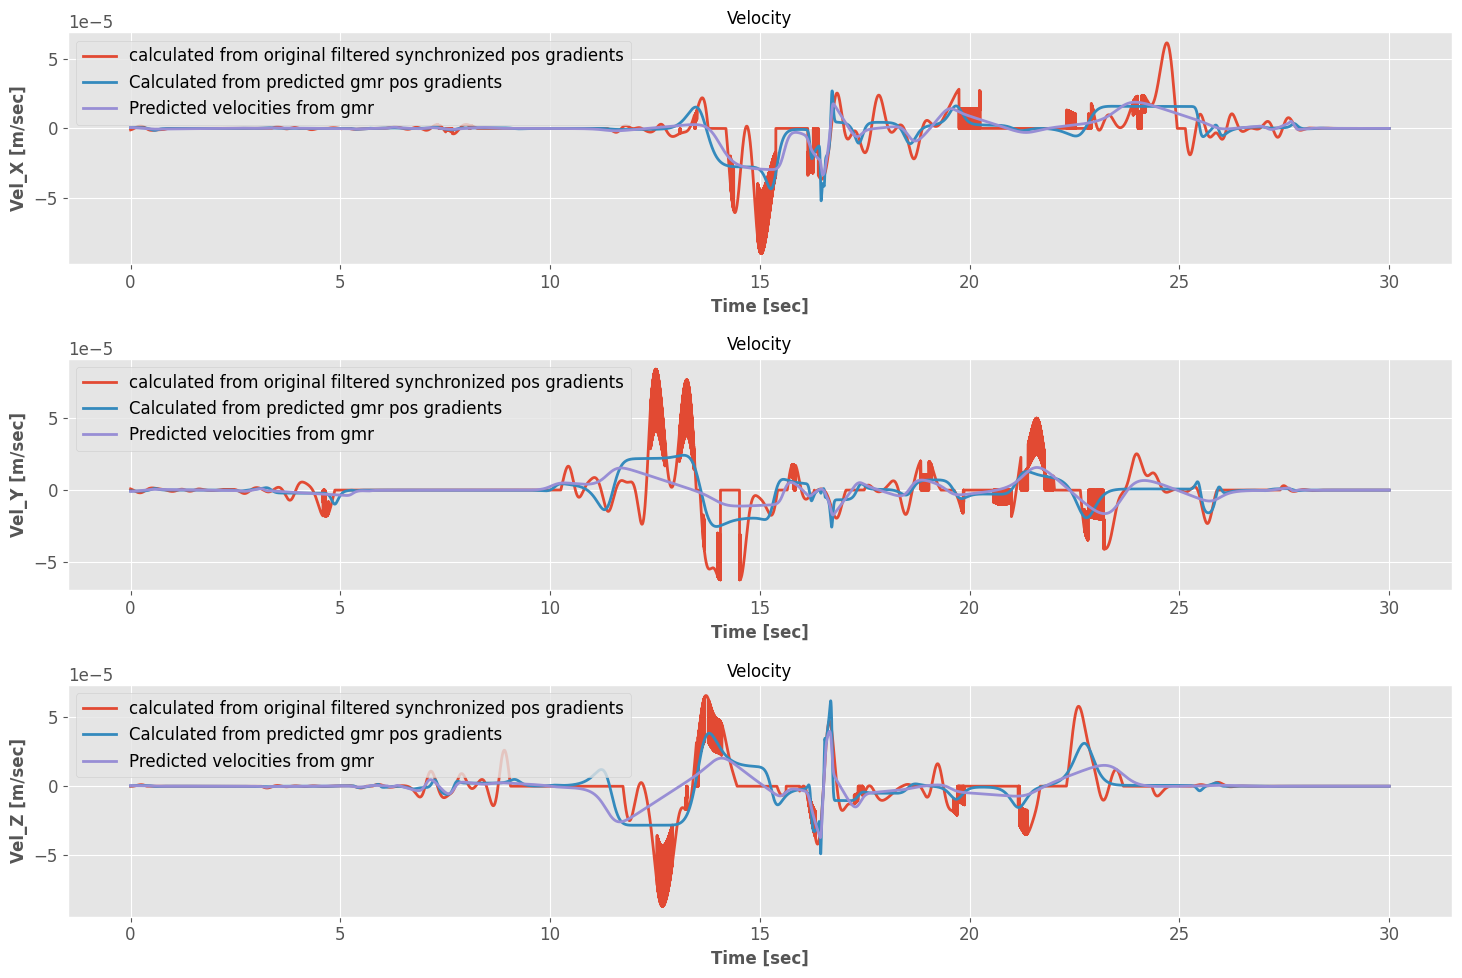

In [42]:
preds_df_with_vel = pd.DataFrame(y_pred, columns= aligned_df1_with_vel.columns)
predicted_vel_from_gmr = preds_df_with_vel[['Vel_X', 'Vel_Y', 'Vel_Z']]
x = np.linspace(0,30,len(predicted_vel_from_gmr))
plt.figure(figsize=(15,10))
for i,c in enumerate(predicted_vel_from_gmr):
    plt.subplot(3,1,i+1)
    # plt.plot(x, preds_vel_gmr[c], label='Predicted by gmr model')

    plt.plot(x, flitered_vel[c], label='calculated from original filtered synchronized pos gradients')
    plt.plot(x, preds_vel[c], label='Calculated from predicted gmr pos gradients')
    plt.plot(x, predicted_vel_from_gmr[c], label="Predicted velocities from gmr")
    plt.legend(loc='upper left')
    plt.title('Velocity')
    plt.xlabel('Time [sec]')
    plt.ylabel(f'{c} [m/sec]')
    plt.tight_layout()


### Save model weights for gmr without velocities

In [44]:
import joblib
joblib.dump(gmm, 'gmr_model_weights.pkl')

['gmr_model_weights.pkl']

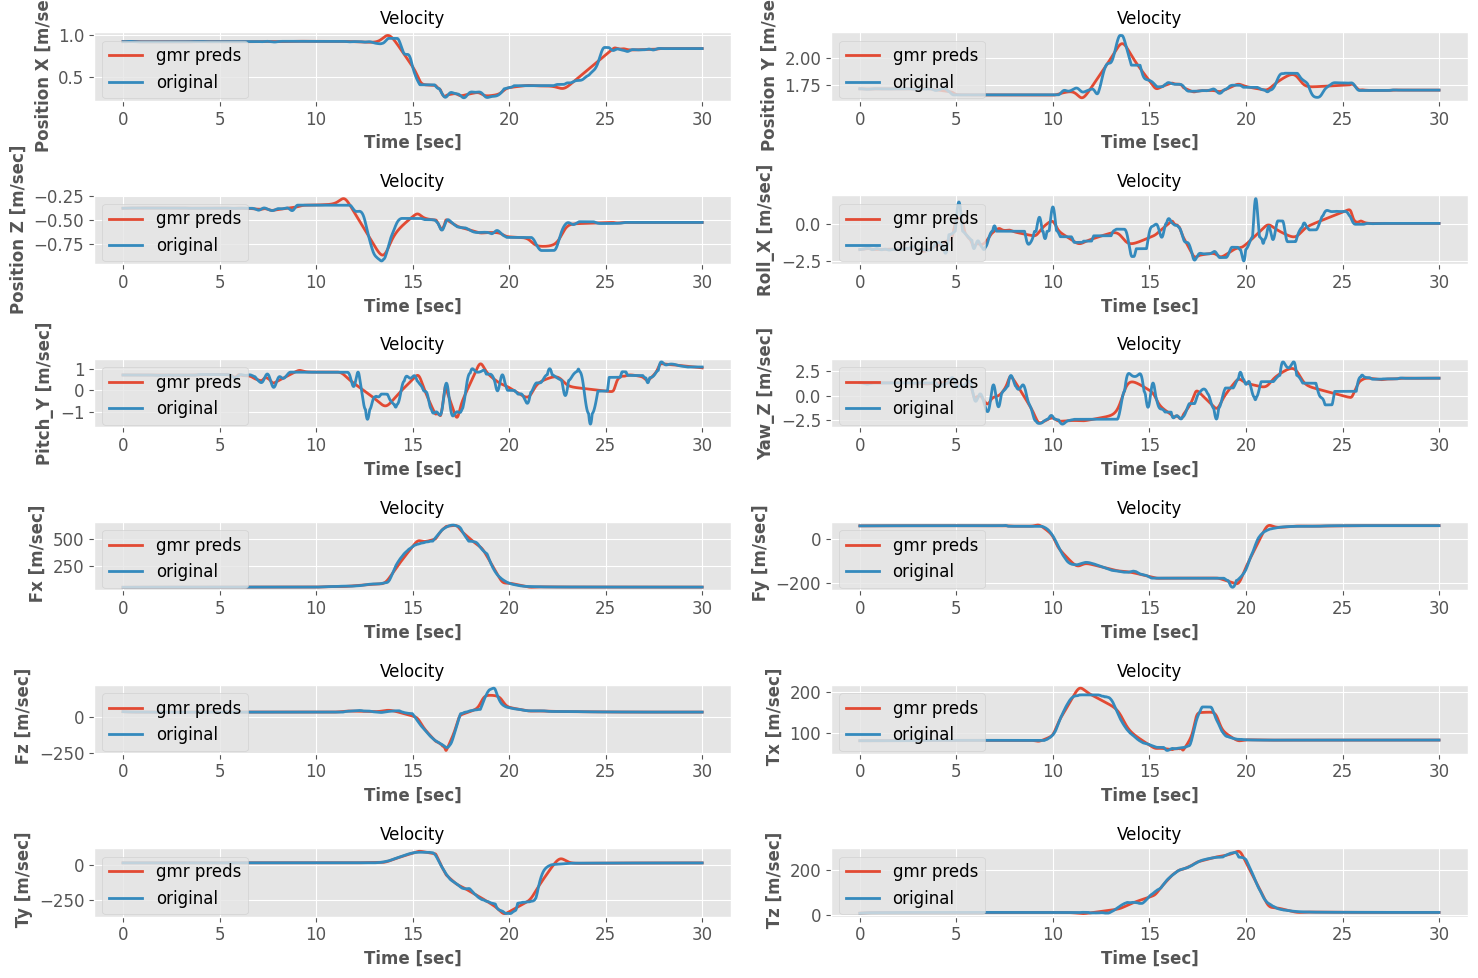

In [48]:
loaded_gmr_model = joblib.load('gmr_model_weights.pkl')
y_pred = loaded_gmr_model.predict(np.array([0]), x[:, np.newaxis])
y_pred
x = np.linspace(0,30,len(aligned_df1))
plt.figure(figsize=(15,10))
for i,c in enumerate(aligned_df1.columns):
    plt.subplot(len(aligned_df1.columns)//2,2,i+1)
    # plt.plot(x, preds_vel_gmr[c], label='Predicted by gmr model')

    plt.plot(x, y_pred[:,i], label='gmr preds')
    plt.plot(x, aligned_df1[c], label='original')
    # plt.plot(x, predicted_vel_from_gmr[c], label="Predicted velocities from gmr")
    plt.legend(loc='upper left')
    plt.title('Velocity')
    plt.xlabel('Time [sec]')
    plt.ylabel(f'{c} [m/sec]')
    plt.tight_layout()

### Saving gmr model wights with velocities

In [49]:
joblib.dump(gmm_with_vel, "gmr_weights_with_vel.pkl")

['gmr_weights_with_vel.pkl']

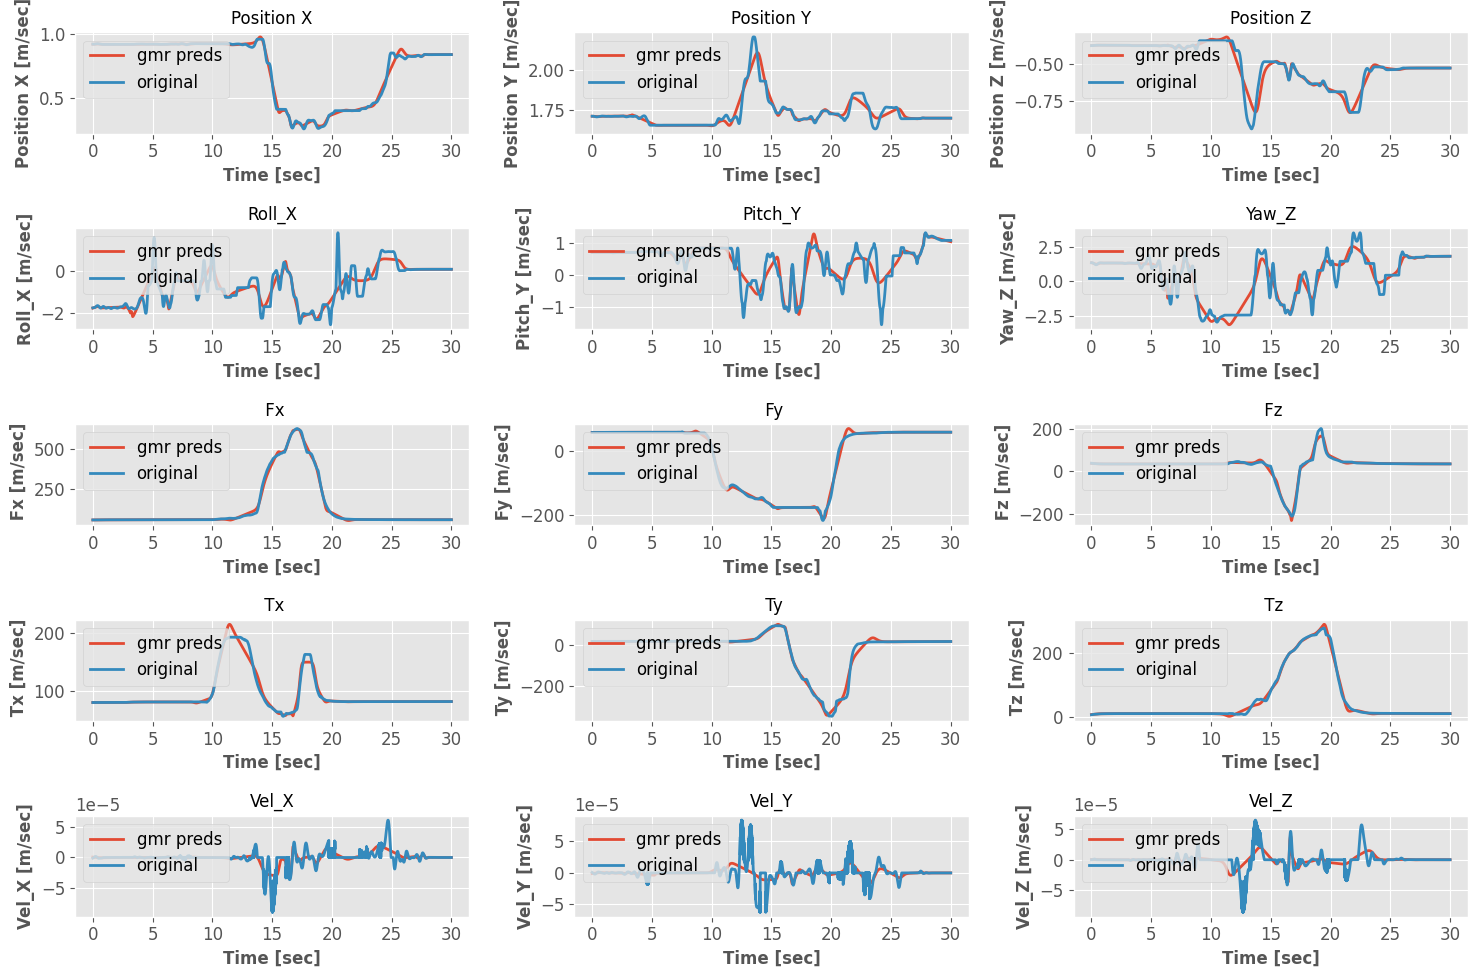

In [52]:
loaded_gmr_model_with_vel = joblib.load('gmr_weights_with_vel.pkl')
y_pred = loaded_gmr_model_with_vel.predict(np.array([0]), x[:, np.newaxis])
# y_pred
x = np.linspace(0,30,len(aligned_df1_with_vel))
plt.figure(figsize=(15,10))
for i,c in enumerate(aligned_df1_with_vel.columns):
    plt.subplot(len(aligned_df1_with_vel.columns)//3,3,i+1)
    # plt.plot(x, preds_vel_gmr[c], label='Predicted by gmr model')

    plt.plot(x, y_pred[:,i], label='gmr preds')
    plt.plot(x, aligned_df1_with_vel[c], label='original')
    # plt.plot(x, predicted_vel_from_gmr[c], label="Predicted velocities from gmr")
    plt.legend(loc='upper left')
    plt.title(c)
    plt.xlabel('Time [sec]')
    plt.ylabel(f'{c} [m/sec]')
    plt.tight_layout()

### Cross validation evaluation for GMR

In [37]:
from sklearn.model_selection import KFold, TimeSeriesSplit, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
from gmr import GMM
import numpy as np

scaler = MinMaxScaler()
data = scaler.fit_transform(synchronized_data_filtered)
synchronized_data_filtered_scaled = pd.DataFrame(data, columns=synchronized_data_filtered.columns)

# Generating synthetic data of 13 columns and 1000 rows
np.random.seed(42)
x = np.linspace(0, 30, len(synchronized_data_filtered_scaled))
time_data = x  # Synthetic time data
output_data = synchronized_data_filtered_scaled.values  # Synthetic output data

# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store evaluation metrics
mse_scores = []
rmse_scores = []
r2_scores = []

# Initialize KFold
# kf = KFold(n_splits=num_folds, shuffle=False)
tscv = TimeSeriesSplit(n_splits=num_folds)
loocv = LeaveOneOut()
# Perform K-Fold Cross-Validation
fold = 1
gmm = GMM(n_components=30)  # You can adjust the number of components as needed
for train_index, test_index in tscv.split(time_data):
    print(f"Fold {fold}")

    # Split the data into training and testing sets for this fold
    X_train, X_test = time_data[train_index], time_data[test_index]
    y_train, y_test = output_data[train_index], output_data[test_index]
    XY_train = np.column_stack((X_train, y_train))
    # Fit the GMM model
    # gmm = GMM(n_components=30)  # You can adjust the number of components as needed
    gmm.from_samples(XY_train)

    # Create GMR model from the fitted GMM
    # gmr = GMR(gmm)

    # Predict output for test data using GMR
    predicted_output = gmm.predict(np.array([0]), X_test[:,np.newaxis]) #np.array([0]), x[:,np.newaxis]

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, predicted_output)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predicted_output)

    # Append scores to lists
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Print metrics for this fold
    print(f"MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

    # Move to the next fold
    fold += 1

# Calculate average scores across all folds
avg_mse = np.mean(mse_scores)
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)

# Print average scores
print(f"\nAverage MSE across {num_folds} folds: {avg_mse}")
print(f"Average RMSE across {num_folds} folds: {avg_rmse}")
print(f"Average R-squared across {num_folds} folds: {avg_r2}")


Fold 1
MSE: 0.0009028865135806245, RMSE: 0.030048070047519266, R-squared: -1120.172775441846
Fold 2
MSE: 0.012611209960510577, RMSE: 0.1122996436348334, R-squared: -6.830914658422955
Fold 3
MSE: 0.574867827068731, RMSE: 0.758200387146255, R-squared: -36.701053175669145
Fold 4
MSE: 0.13536938656886838, RMSE: 0.36792578948596194, R-squared: -2.619935381002079
Fold 5
MSE: 0.30707035959923795, RMSE: 0.5541392962056002, R-squared: -89.62344253413114
Fold 6
MSE: 0.19120985712142569, RMSE: 0.4372754933922386, R-squared: -23.482951926318396
Fold 7
MSE: 0.386897220980303, RMSE: 0.6220106277068769, R-squared: -8.550843614222606
Fold 8
MSE: 0.40164618485439724, RMSE: 0.6337556191896031, R-squared: -729.7602863098609
Fold 9
MSE: 0.5729672777742193, RMSE: 0.7569460203833688, R-squared: -72925.85634486846
Fold 10
MSE: 0.5140603812365235, RMSE: 0.7169800424255361, R-squared: -25119326.560945775

Average MSE across 10 folds: 0.3097602591677798
Average RMSE across 10 folds: 0.4989580989617794
Average R

In [69]:
mse_scores[-1]

[0.5140603812365235]

In [40]:
rmse_scores

[0.030048070047519266,
 0.1122996436348334,
 0.758200387146255,
 0.36792578948596194,
 0.5541392962056002,
 0.4372754933922386,
 0.6220106277068769,
 0.6337556191896031,
 0.7569460203833688,
 0.7169800424255361]

# Training RNN model for forecasting (TODO)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define parameters
timesteps = 100  # Define the number of time steps (sequence length)
features = df_imputed.shape[1]   # Define the number of features in your dataset
future_steps = 5  # Number of future time steps to forecast for each feature
# Reshape the data into sequences for RNN training
sequences = []
for i in range(len(data) - timesteps):
    sequence = data[i:i+timesteps]
    sequences.append(sequence)

sequences = np.array(sequences)

# Reshaping for RNN input (samples, timesteps, features)
sequences = np.reshape(sequences, (sequences.shape[0], timesteps, features))

# Display the shape of the reshaped sequences
print("Shape of sequences:", sequences.shape)

# Generating sample data (replace this with your dataset)
# Sample data with shape: (samples, timesteps, features)
data = sequences

# Splitting the data into input and target sequences
x_train = data[:, :timesteps-future_steps, :]
y_train = data[:, future_steps:, :]  # Predicting 'future_steps' ahead for each feature

# Creating the LSTM-based model
model = Sequential()

# LSTM layers for sequence modeling
model.add(LSTM(units=128, return_sequences=True, input_shape=(timesteps - future_steps, features)))
model.add(LSTM(units=64, return_sequences=True))

# Dense layer for predicting each feature at future time steps
model.add(Dense(units=features * future_steps))  # Output shape: (batch_size, (features * future_steps))

# Reshape output to match target shape
model.add(Dense(features))  # Output shape: (batch_size, timesteps - future_steps, features * future_steps)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions on the test data
predicted_test = model.predict(X_test_reshaped)

# Plotting actual vs predicted values for one feature (assuming you're interested in the first feature)
feature_index = 3  # Change this to visualize a different feature
plt.figure(figsize=(10, 6))
plt.plot(X_test[timesteps - 1:, feature_index], label='Actual')
plt.plot(predicted_test[:, feature_index], label='Predicted')
plt.title('Actual vs Predicted Values for Feature {}'.format(feature_index))
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


NameError: ignored

### RNN prediction visualisation